In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

In [3]:
from datetime import datetime, timedelta
import pandas_datareader.data as web
import re

def clean_event_data(event_file_path):
    df_events = pd.read_csv(event_file_path)

    df_events['Announced_Date_Orig'] = df_events['Announced']
    df_events['Trade_Date_Orig'] = df_events['Trade Date']

    df_events['Announced'] = pd.to_datetime(df_events['Announced'], errors='coerce')
    df_events['Trade Date'] = pd.to_datetime(df_events['Trade Date'], errors='coerce')

    anomaly_mask = (df_events['Announced'] == datetime(2023, 12, 2)) & (df_events['Trade Date'] == datetime(2022, 12, 16))

    num_anomalies = anomaly_mask.sum()
    if num_anomalies > 0:
        print(f"Correcting {num_anomalies} date anomalies (Announced: 2023-12-02, Trade Date: 2022-12-16) to Announced: 2022-12-02.")
        df_events.loc[anomaly_mask, 'Trade Date'] = datetime(2023, 12, 18)

    def normalize_ticker(ticker_str):
        if pd.isna(ticker_str):
            return None
        ticker_str = ticker_str.strip()

        if ticker_str.endswith(" US"):
            ticker_str = ticker_str[:-3]

        if '.' in ticker_str:
            parts = ticker_str.split('.')
            if len(parts) == 2 and len(parts[1]) == 1:
                if parts[1].isalpha() and parts[1].isupper():
                    ticker_str = parts[0] + '-' + parts[1]

        if bool(re.search(r"[a-z]", ticker_str)):
            ticker_str = re.sub('[^A-Z]', '', ticker_str)
        return ticker_str

    df_events['Ticker_Orig'] = df_events['Ticker']
    df_events['Normalized_Ticker'] = df_events['Ticker'].apply(normalize_ticker)

    #remove delisted tickers
    # GRALV just striaght up was never added to the S&P400 lol
    # FBHS was replaced on the S&P500, announced dec 12
    # PACW was merged into Banc of Cali, BANC
    # SIX trades under FUN now after acquiring cedar entertainment, price didnt match so i just removed it
    # SNDK also listed as SNDKV, not sure why
    # NATL (NCR Atleos) joined the S&P 600 while its parent company NCR Voyix stayed in the S&P400
    delisted_tickers = ['AGTI', 'CBTX', 'NEX', 'GRALV', 'HTA', 'FBHS', 'PACW', 'FTREV', 'SIX', 'AVID', 'SNDKV']
    df_events = df_events[~df_events['Normalized_Ticker'].isin(delisted_tickers)]
    #fix typo tickers:
    typo_tickers = {'STHOV': 'STHO', 'CHK':'EXE', 'GEHCV':'GEHC'}
    for bad_ticker, correct_ticker in typo_tickers.items():
        df_events.loc[df_events['Normalized_Ticker'] == bad_ticker, 'Normalized_Ticker'] = correct_ticker

    def clean_numeric_col(series, remove_chars):
        series_str = series.astype(str)
        for char in remove_chars:
            series_str = series_str.str.replace(char, '', regex=False)
        series_str = series_str.replace('-', np.nan, regex=False)
        series_str = series_str.str.strip()
        series_str.loc[series_str == ''] = np.nan # Replace empty strings
        return pd.to_numeric(series_str, errors='coerce')

    df_events['Last Px'] = clean_numeric_col(df_events['Last Px'], ['$'])
    df_events['Shs to Trade'] = clean_numeric_col(df_events['Shs to Trade'], [','])
    df_events['$MM to Trade'] = clean_numeric_col(df_events['$MM to Trade'], ['$', ','])
    df_events['ADV to Trade Pct'] = df_events['ADV to Trade'].astype(str).str.replace('%', '', regex=False)
    df_events['ADV to Trade Pct'] = clean_numeric_col(df_events['ADV to Trade Pct'], []) / 100.0

    df_events.rename(columns={'Announced': 'Announce_Date', 'Trade Date': 'Trade_Date'}, inplace=True)

    return df_events.sort_values(by='Announce_Date').reset_index(drop=True)

# --- 2. Fetch FRED Data (Fed Funds Rate) ---
def fetch_fred_data(start_date, end_date):
    print(f"Fetching FRED data (DFF) from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
    try:
        ff_rate = web.DataReader('DFF', 'fred', start_date, end_date)
        ff_rate.rename(columns={'DFF': 'Fed_Funds_Rate'}, inplace=True)
        ff_rate['Fed_Funds_Rate'] = ff_rate['Fed_Funds_Rate'] / 100.0
        # FRED data is daily. We need to ffill for weekends/holidays for merging.
        # Create a complete date range to ensure all days are covered
        all_days = pd.date_range(start=ff_rate.index.min(), end=ff_rate.index.max(), freq='D')
        ff_rate = ff_rate.reindex(all_days).ffill()
        return ff_rate
    except Exception as e:
        print(f"Error fetching FRED data: {e}")
        return pd.DataFrame(columns=['Fed_Funds_Rate']) # Return empty df on error


# --- 3. Fetch Stock Price Data ---
def fetch_price_data(tickers_list, start_date, end_date):
    print(f"Fetching stock price data for {len(tickers_list)} tickers from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}...")
    # yfinance can be slow for many tickers one by one; batch download is better.
    # It can also return a multi-index Panel, or a dict of DataFrames if group_by='ticker'.

    # Some tickers might have issues (e.g., delisted, different symbol in yfinance)
    # We'll download in batches to be more robust and identify problematic tickers
    all_price_data = {}
    problematic_tickers = []

    # yfinance expects space-separated string for multiple tickers
    # For very large lists, yfinance might still struggle.
    # A more robust way is to loop, but it's slower. Let's try batch first.
    try:
        data = yf.download(tickers_list, start=start_date, end=end_date, progress=False, group_by='ticker')

        for ticker in tickers_list:
            if ticker in data and not data[ticker].empty:
                all_price_data[ticker] = data[ticker][['Open', 'High', 'Low', 'Close', 'Volume']]
            elif ticker.replace('-', '.') in data and not data[ticker.replace('-', '.')].empty: # yfinance sometimes uses '.' e.g. BRK.B
                all_price_data[ticker] = data[ticker.replace('-', '.')][['Open', 'High', 'Low', 'Close', 'Volume']]
            else:
                # Try with common variations if primary failed
                # e.g. if ticker was BRK.B and normalized to BRK-B, yfinance might still use BRK.B
                alternative_ticker = ticker.replace('-', '.')
                if alternative_ticker in data and not data[alternative_ticker].empty:
                    all_price_data[ticker] = data[alternative_ticker][['Open', 'High', 'Low', 'Close', 'Volume']]
                else:
                    # If still not found or empty after trying common variations, try individual download as a last resort
                    try:
                        single_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                        if not single_data.empty:
                             all_price_data[ticker] = single_data[['Open', 'High', 'Low', 'Close', 'Volume']]
                        else:
                            problematic_tickers.append(ticker)
                    except Exception:
                         problematic_tickers.append(ticker)

        if not all_price_data:
            print("No price data fetched. Check ticker symbols or date range.")
            return pd.DataFrame(), problematic_tickers

        # Combine into a single multi-index DataFrame
        combined_df = pd.concat(all_price_data, names=['Ticker', 'Date'])
        print(combined_df)
        combined_df.reset_index(inplace=True)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        combined_df.set_index(['Date', 'Ticker'], inplace=True)
        combined_df.sort_index(inplace=True)

    except Exception as e:
        print(f"Major error during batch yfinance download: {e}. Some data may be missing.")
        # Fallback or iterative download might be needed if this is common
        # For now, we'll proceed with what we got, if any
        if not all_price_data:
             return pd.DataFrame(), tickers_list # Assume all failed if major error and no data
        combined_df = pd.concat(all_price_data, names=['Ticker', 'Date'])
        combined_df.reset_index(inplace=True)
        combined_df['Date'] = pd.to_datetime(combined_df['Date'])
        combined_df.set_index(['Date', 'Ticker'], inplace=True)
        combined_df.sort_index(inplace=True)


    if problematic_tickers:
        print(f"Could not fetch data for the following {len(problematic_tickers)} tickers: {problematic_tickers}")

    return combined_df, problematic_tickers

# --- 4. Calculate ADV ---
def calculate_adv(price_df, window=20):
    print(f"Calculating {window}-day ADV...")
    if 'Volume' not in price_df.columns:
        print("Volume data not found. Cannot calculate ADV.")
        price_df['ADV_20'] = np.nan
        return price_df
    # Calculate ADV: mean of past 'window' days' volume. Shift(1) to use data prior to current day.
    price_df['ADV_20'] = price_df.groupby(level='Ticker')['Volume'].transform(
        lambda x: x.rolling(window=window, min_periods=max(1,window//2)).mean().shift(1) # min_periods to get some value even if not full window
    )
    return price_df



In [4]:
# --- Main Execution Flow ---
EVENT_FILE_PATH = "idexAddData.csv"

df_events_cleaned = clean_event_data(EVENT_FILE_PATH)

if not df_events_cleaned.empty:
    print(f"\nCleaned Event Data Summary:")
    print(f"Shape: {df_events_cleaned.shape}")
    print(f"Date range (Announce_Date): {df_events_cleaned['Announce_Date'].min()} to {df_events_cleaned['Announce_Date'].max()}")
    print(f"Date range (Effective_Date): {df_events_cleaned['Trade_Date'].min()} to {df_events_cleaned['Trade_Date'].max()}")
    print(f"Unique normalized tickers: {df_events_cleaned['Normalized_Ticker'].nunique()}")
    # print("Sample of cleaned event data:")
    #print(df_events_cleaned[['Announce_Date', 'Trade_Date', 'Index', 'Ticker_Orig', 'Normalized_Ticker', 'Last Px', 'ADV to Trade Pct']].head())

    # 2. Determine overall date range for fetching auxiliary data
    # Buffer for ADV calculation (e.g., 20 trading days + buffer ~ 45 calendar days)
    # Buffer for holding period (e.g., 1 month ~ 30 calendar days, plus another 30 for safety for max holding period)
    data_fetch_start_date = df_events_cleaned['Announce_Date'].min() - timedelta(days=45)
    data_fetch_end_date = df_events_cleaned['Trade_Date'].max() + timedelta(days=60) # Increased buffer for 1-month hold + slippage

    # 3. Fetch FRED data
    fred_rates = fetch_fred_data(data_fetch_start_date, data_fetch_end_date)
    # print("\nSample of FRED data (Fed Funds Rate):")
    # print(fred_rates.tail())

    # 4. Fetch stock price data
    unique_tickers_list = df_events_cleaned['Normalized_Ticker'].dropna().unique().tolist()

    stock_price_data_multi, problematic_tickers = fetch_price_data(unique_tickers_list, data_fetch_start_date, data_fetch_end_date)

    if not stock_price_data_multi.empty:
        # print("\nSample of fetched stock price data (MultiIndex):")
        # print(stock_price_data_multi.head())
        # print(stock_price_data_multi.tail())

        # 5. Calculate ADV
        stock_price_data_multi = calculate_adv(stock_price_data_multi, window=20)
        # print("\nSample of stock price data with ADV_20:")
        # print(stock_price_data_multi.dropna(subset=['ADV_20']).head())

        # --- Filter out events for which we couldn't get price data ---
        original_event_count = len(df_events_cleaned)
        # Get tickers for which we successfully fetched data
        successful_tickers = stock_price_data_multi.index.get_level_values('Ticker').unique().tolist()
        df_events_cleaned = df_events_cleaned[df_events_cleaned['Normalized_Ticker'].isin(successful_tickers)]
        print(f"\nFiltered events to keep only those with available price data. Kept {len(df_events_cleaned)} events out of {original_event_count}.")
        print(f"Dropped {original_event_count - len(df_events_cleaned)} events due to missing price data for their tickers.")

        # --- Ready for merging and strategy implementation ---
        print("\nData preparation complete. Ready for merging and strategy backtesting.")
        # For merging, we'll typically iterate through df_events_cleaned and pick relevant price data.
        # Example: For each event, find price on Announce_Date + 1 day (Open), price on Effective_Date (Open/Close).
        # Also merge Fed Funds rate for relevant dates.
    else:
        print("\nFailed to fetch any stock price data. Cannot proceed with ADV calculation or backtesting.")
else:
    print("\nEvent data is empty after cleaning/filtering. Cannot proceed.")

Correcting 5 date anomalies (Announced: 2023-12-02, Trade Date: 2022-12-16) to Announced: 2022-12-02.

Cleaned Event Data Summary:
Shape: (167, 15)
Date range (Announce_Date): 2022-05-12 00:00:00 to 2025-04-28 00:00:00
Date range (Effective_Date): 2022-05-16 00:00:00 to 2025-04-30 00:00:00
Unique normalized tickers: 167
Fetching FRED data (DFF) from 2022-03-28 to 2025-06-29...
Fetching stock price data for 167 tickers from 2022-03-28 to 2025-06-29...
YF.download() has changed argument auto_adjust default to True
Price                    Open        High         Low       Close     Volume
Ticker Date                                                                 
AOSL   2022-03-28   65.000000   66.970001   62.380001   64.949997   569800.0
       2022-03-29   65.550003   66.610001   63.369999   65.300003   546800.0
       2022-03-30   65.610001   69.989998   62.759998   63.020000  1446200.0
       2022-03-31   63.020000   63.020000   54.310001   54.650002  1910500.0
       2022-04-01   

In [5]:
df_events_cleaned

,Announce_Date,Trade_Date,Index,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade,Announced_Date_Orig,Trade_Date_Orig,Ticker_Orig,Normalized_Ticker,ADV to Trade Pct
0,2022-05-12,2022-05-18,S&P 600,AOSL,Add,33.20,Info Tech,2772855.0,92.1,468%,5/12/2022,5/18/2022,AOSL,AOSL,4.68
1,2022-05-12,2022-05-18,S&P 400,IRT,Add,22.44,Real Estate,24230554.0,543.7,689%,5/12/2022,5/18/2022,IRT,IRT,6.89
2,2022-05-12,2022-05-16,S&P 600,DVAX,Add,7.93,Healthcare,14658374.0,116.2,846%,5/12/2022,5/16/2022,DVAX,DVAX,8.46
3,2022-06-03,2022-06-07,S&P 500,VICI,Add,32.45,Real Estate,146440651.0,4752.0,906%,6/3/2022,6/7/2022,VICI,VICI,9.06
4,2022-06-13,2022-06-15,S&P 600,EYE,Add,39.62,Cons Disc,11230796.0,NaN,1617%,6/13/2022,6/15/2022,EYE,EYE,16.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2025-03-26,2025-03-28,S&P 400,CAVA US,Add,86.67,Cons Disc,8961552.0,776.7,223%,3/26/2025,3/28/2025,CAVA US,CAVA,2.23
163,2025-03-26,2025-04-01,S&P 600,ANGI US,Add,16.43,Comm Svcs,886941.0,14.6,454%,3/26/2025,4/1/2025,ANGI US,ANGI,4.54
164,2025-04-09,2025-04-15,S&P 600,ACT US,Add,33.37,Financials,3863743.0,128.9,1536%,4/9/2025,4/15/2025,ACT US,ACT,15.36
165,2025-04-14,2025-04-16,S&P 600,STRL US,Add,135.23,Industrials,4004975.0,541.6,528%,4/14/2025,4/16/2025,STRL US,STRL,5.28


In [6]:
stock_price_data_multi

Price                    Open        High         Low       Close     Volume  \
Date       Ticker                                                              
2022-03-28 AAON     34.574804   34.633829   33.564840   34.220661   254850.0   
           AAP     199.244177  199.244177  193.845990  194.233551   706100.0   
           ABR      11.727394   11.809308   11.665958   11.734221  1526700.0   
           ACAD     26.700001   27.370001   24.150000   24.650000  2112900.0   
           ACGL     45.300805   45.329330   44.834866   45.262768  1261900.0   
...                       ...         ...         ...         ...        ...   
2025-05-22 WLK      73.120003   73.459999   71.760002   72.339996  1284900.0   
           WMS     110.629997  111.830002  108.750000  111.000000   859000.0   
           WPC      60.330002   60.509998   59.770000   60.220001  1401500.0   
           XPER      7.800000    7.920000    7.740000    7.740000   158600.0   
           ZI        9.500000    9.620000    9.460000    9.550000  3620896.0   

Price                  ADV_20  
Date       Ticker              
2022-03-28 AAON           NaN  
           AAP            NaN  
           ABR            NaN  
           ACAD           NaN  
           ACGL           NaN  
...                       ...  
2025-05-22 WLK     1274085.00  
           WMS      762790.00  
           WPC      977135.00  
           XPER     393200.00  
           ZI      5714325.85  

[132264 rows x 6 columns]

In [7]:
df_events_cleaned['Entry_Date_Strat1'] = pd.NaT
df_events_cleaned['Entry_Price_Strat1'] = np.nan
df_events_cleaned['Exit_Date_Strat1'] = pd.NaT
df_events_cleaned['Exit_Price_Strat1'] = np.nan
df_events_cleaned['Pct_Change_Strat1'] = np.nan


for index, event_row in df_events_cleaned.iterrows():
    ticker = event_row['Normalized_Ticker']
    announce_date = event_row['Announce_Date']
    effective_date = event_row['Trade_Date']

    # --- Determine Entry Date and Price ---
    # Entry is the open on the first trading day *after* announce_date
    # We query stock_price_data_multi for the ticker, for dates > announce_date, take the first one.

    try:
        # Select relevant ticker data and dates strictly after announcement
        # Ensure the ticker exists in the stock_price_data_multi index
        if ticker not in stock_price_data_multi.index.get_level_values('Ticker').unique():
            # print(f"Ticker {ticker} not found in stock_price_data_multi. Skipping event index {index}.")
            continue

        potential_entry_days = stock_price_data_multi.loc[(slice(announce_date + pd.Timedelta(days=1), None), ticker), :]

        if not potential_entry_days.empty:
            actual_entry_day_data = potential_entry_days.iloc[0] # First trading day after announcement
            entry_date = actual_entry_day_data.name[0] # Get the Date from the (Date, Ticker) index
            entry_price = actual_entry_day_data['Open']

            df_events_cleaned.loc[index, 'Entry_Date_Strat1'] = entry_date
            df_events_cleaned.loc[index, 'Entry_Price_Strat1'] = entry_price
        else:
            print(f"No price data found after Announce_Date for {ticker} (Event index {index}). Cannot determine entry price.")
            continue # Skip if no entry price

        # --- Determine Exit Date and Price ---
        # Exit is the close on the Effective_Date (which is 'Trade Date' in the project doc)
        # The strategy note says "Exit any day before or on the index 'trade date'".
        # For this analysis, we'll use "close on trade date" as the exit.
        # For backtesting, we'll need to be more precise about exit timing.

        df_events_cleaned.loc[index, 'Exit_Date_Strat1'] = effective_date # Storing the target exit date

        # Check if effective_date exists for the ticker
        if (effective_date, ticker) in stock_price_data_multi.index:
            exit_price = stock_price_data_multi.loc[(effective_date, ticker), 'Close']
            df_events_cleaned.loc[index, 'Exit_Price_Strat1'] = exit_price
        else:
            # If exact effective_date is not a trading day or no data, try to find the closest previous trading day's close.
            # For this initial analysis of "price on Effective_Date", let's stick to exact.
            # If data is missing, it will remain NaN.
            print(f"No price data found on Effective_Date {effective_date} for {ticker} (Event index {index}). Cannot determine exit price.")
            continue # Skip if no exit price for calculation

        # --- Calculate Percentage Change ---
        if pd.notna(entry_price) and pd.notna(exit_price) and entry_price != 0:
            pct_change = (exit_price - entry_price) / entry_price
            df_events_cleaned.loc[index, 'Pct_Change_Strat1'] = pct_change
        else:
            # print(f"Could not calculate Pct_Change for {ticker} (Event index {index}) due to missing prices or zero entry price.")
            pass

    except KeyError:
        # This can happen if a ticker is in df_events_cleaned but not in stock_price_data_multi after all filters
        # Or if indexing on dates fails unexpectedly.
        # print(f"KeyError encountered for ticker {ticker} or dates around event index {index}. Skipping.")
        continue
    except Exception as e:
        # print(f"An unexpected error occurred for ticker {ticker}, event index {index}: {e}. Skipping.")
        continue


# Add the 'abs_price_change' column
df_events_cleaned['Abs_Pct_Change_Strat1'] = df_events_cleaned['Pct_Change_Strat1'].abs()

print("\nCalculation complete. 'Pct_Change_Strat1' and 'Abs_Pct_Change_Strat1' added to df_events_cleaned.")
print("Summary of new columns:")
print(df_events_cleaned[['Announce_Date', 'Normalized_Ticker', 'Entry_Date_Strat1', 'Entry_Price_Strat1',
                         'Trade_Date', 'Exit_Price_Strat1', 'Pct_Change_Strat1', 'Abs_Pct_Change_Strat1']].head())

print("\nDescriptive statistics for Pct_Change_Strat1:")
print(df_events_cleaned['Pct_Change_Strat1'].describe())

print("\nDescriptive statistics for Abs_Pct_Change_Strat1:")
print(df_events_cleaned['Abs_Pct_Change_Strat1'].describe())

# Count of events where calculation was successful
print("\n doggy row")
df_events_cleaned.loc[df_events_cleaned['Pct_Change_Strat1'].isna(), 'Index'] = 'S&P 600'
print(df_events_cleaned.loc[df_events_cleaned['Pct_Change_Strat1'].isna()])
successful_calcs = df_events_cleaned['Pct_Change_Strat1'].notna().sum()
total_events = len(df_events_cleaned)
print(f"\nSuccessfully calculated price changes for {successful_calcs} out of {total_events} events processed for this step.")
#NATL(NCR Atleos spun off on OCT 17, first tradable date was on the 16th)


Calculation complete. 'Pct_Change_Strat1' and 'Abs_Pct_Change_Strat1' added to df_events_cleaned.
Summary of new columns:
  Announce_Date Normalized_Ticker Entry_Date_Strat1  Entry_Price_Strat1  \
0    2022-05-12              AOSL        2022-05-13           38.230000   
1    2022-05-12               IRT        2022-05-13           19.733495   
2    2022-05-12              DVAX        2022-05-13            9.000000   
3    2022-06-03              VICI        2022-06-06           28.641829   
4    2022-06-13               EYE        2022-06-14           28.299999   

  Trade_Date  Exit_Price_Strat1  Pct_Change_Strat1  Abs_Pct_Change_Strat1  
0 2022-05-18          39.910000           0.043945               0.043945  
1 2022-05-18          19.967451           0.011856               0.011856  
2 2022-05-16           9.820000           0.091111               0.091111  
3 2022-06-07          27.445217          -0.041778               0.041778  
4 2022-06-15          27.799999          -0.01

Number of positive changes: 87
Number of negative changes: 78


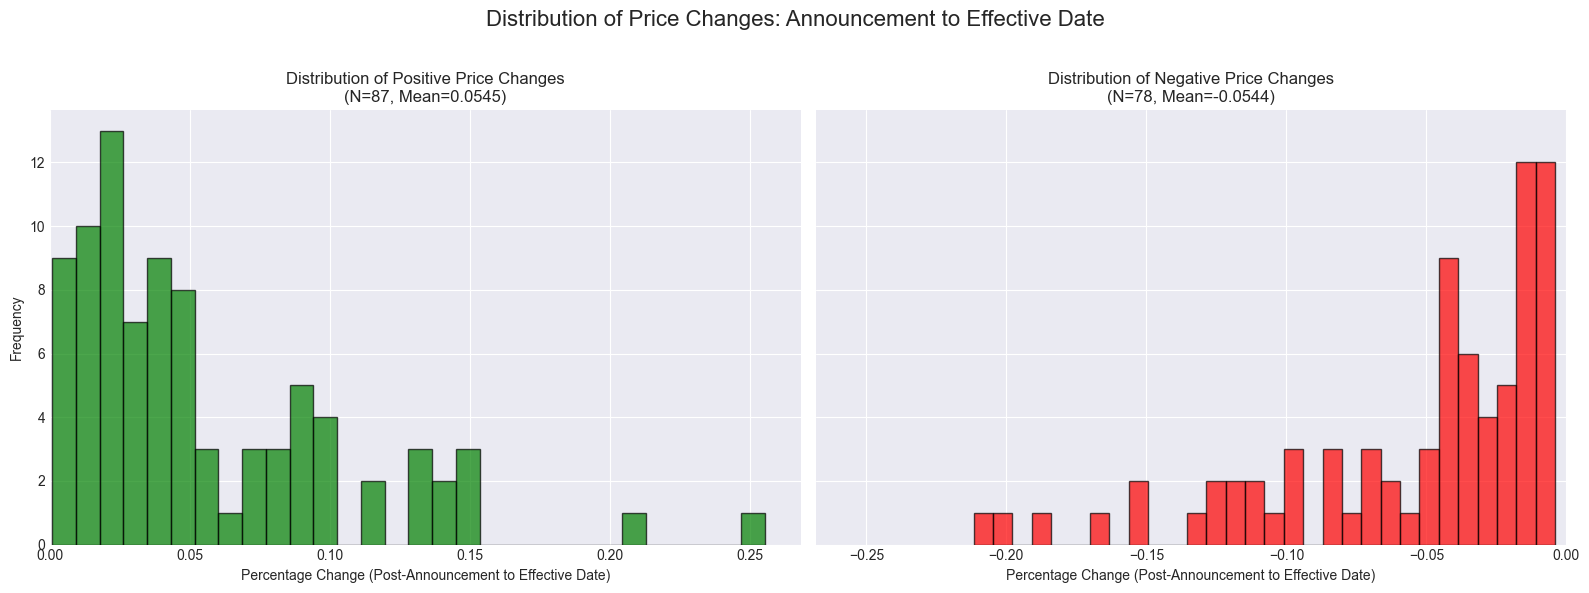


--- Statistics for Positive Changes ---
count    87.000000
mean      0.054456
std       0.049272
min       0.000764
25%       0.019138
50%       0.038540
75%       0.084158
max       0.255319
Name: Pct_Change_Strat1, dtype: float64

--- Statistics for Negative Changes ---
count    78.000000
mean     -0.054394
std       0.050553
min      -0.211686
25%      -0.079867
50%      -0.038645
75%      -0.016214
max      -0.004025
Name: Pct_Change_Strat1, dtype: float64


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Ensure 'Pct_Change_Strat1' is numeric and drop NaNs for plotting ---
df_plot = df_events_cleaned[['Pct_Change_Strat1']].copy()
df_plot.dropna(subset=['Pct_Change_Strat1'], inplace=True)
df_plot['Pct_Change_Strat1'] = pd.to_numeric(df_plot['Pct_Change_Strat1'], errors='coerce')
df_plot.dropna(subset=['Pct_Change_Strat1'], inplace=True)


if df_plot.empty:
    print("No data available for plotting after cleaning Pct_Change_Strat1.")
else:
    # Separate positive and negative changes
    positive_changes = df_plot[df_plot['Pct_Change_Strat1'] > 0]['Pct_Change_Strat1']
    negative_changes = df_plot[df_plot['Pct_Change_Strat1'] < 0]['Pct_Change_Strat1']

    print(f"Number of positive changes: {len(positive_changes)}")
    print(f"Number of negative changes: {len(negative_changes)}")

    # --- Plotting ---
    # Determine a common bin range for better comparison, or use automatic binning.
    # For percentage changes, a range like -0.2 to 0.2 might be reasonable, but let data guide.
    # Let's find the overall min/max to set somewhat symmetrical bins, or let Matplotlib decide.

    # Overall min and max to help with consistent binning if desired
    # overall_min = df_plot['Pct_Change_Strat1'].min()
    # overall_max = df_plot['Pct_Change_Strat1'].max()
    # Forcing symmetrical x-axis can be good for comparison too.
    # abs_max_val = max(abs(overall_min), abs(overall_max), 0.01) # Ensure not zero for limits

    # Common number of bins
    num_bins = 30

    plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style for better aesthetics

    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True) # Share Y-axis for easier comparison of counts

    # Histogram for Positive Price Changes
    if not positive_changes.empty:
        axes[0].hist(positive_changes, bins=num_bins, color='green', edgecolor='black', alpha=0.7)
        axes[0].set_title(f'Distribution of Positive Price Changes\n(N={len(positive_changes)}, Mean={positive_changes.mean():.4f})')
        axes[0].set_xlabel('Percentage Change (Post-Announcement to Effective Date)')
        axes[0].set_ylabel('Frequency')
        # Potentially set x-limits for positive side
        # axes[0].set_xlim(0, max(positive_changes.max(), 0.1)) # Ensure x-axis starts at 0
    else:
        axes[0].set_title('No Positive Price Changes to Plot')
        axes[0].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)


    # Histogram for Negative Price Changes
    if not negative_changes.empty:
        axes[1].hist(negative_changes, bins=num_bins, color='red', edgecolor='black', alpha=0.7)
        axes[1].set_title(f'Distribution of Negative Price Changes\n(N={len(negative_changes)}, Mean={negative_changes.mean():.4f})')
        axes[1].set_xlabel('Percentage Change (Post-Announcement to Effective Date)')
        # axes[1].set_ylabel('Frequency') # Y-label is shared
        # Potentially set x-limits for negative side
        # axes[1].set_xlim(min(negative_changes.min(), -0.1), 0) # Ensure x-axis ends at 0
    else:
        axes[1].set_title('No Negative Price Changes to Plot')
        axes[1].text(0.5, 0.5, 'No Data', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)

    # Set common x-axis limits based on the overall range of changes for better comparison
    # This makes it easier to compare the spread of positive vs negative.
    # For example, if positive max is 0.15 and negative min is -0.10, set xlim for positive to (0, 0.15) and negative to (-0.15, 0) or similar.
    # Or let them auto-scale and observe.

    # Let's try to make the scales comparable if desired.
    # E.g., find max absolute deviation for setting limits.
    if not positive_changes.empty and not negative_changes.empty:
        max_abs_dev_pos = positive_changes.max()
        max_abs_dev_neg = abs(negative_changes.min())
        overall_max_abs_dev = max(max_abs_dev_pos, max_abs_dev_neg, 0.01) # Avoid zero if all changes are tiny

        axes[0].set_xlim(0, overall_max_abs_dev * 1.05) # Add 5% buffer
        axes[1].set_xlim(-overall_max_abs_dev * 1.05, 0) # Add 5% buffer
    elif not positive_changes.empty:
         axes[0].set_xlim(0, positive_changes.max() * 1.05 if positive_changes.max() > 0 else 0.01)
    elif not negative_changes.empty:
        axes[1].set_xlim(negative_changes.min() * 1.05 if negative_changes.min() < 0 else -0.01, 0)


    fig.suptitle('Distribution of Price Changes: Announcement to Effective Date', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()

    print("\n--- Statistics for Positive Changes ---")
    if not positive_changes.empty:
        print(positive_changes.describe())
    else:
        print("No positive changes found.")

    print("\n--- Statistics for Negative Changes ---")
    if not negative_changes.empty:
        print(negative_changes.describe())
    else:
        print("No negative changes found.")

Plotting histogram for 'Pct_Change_Strat1' based on 166 data points.


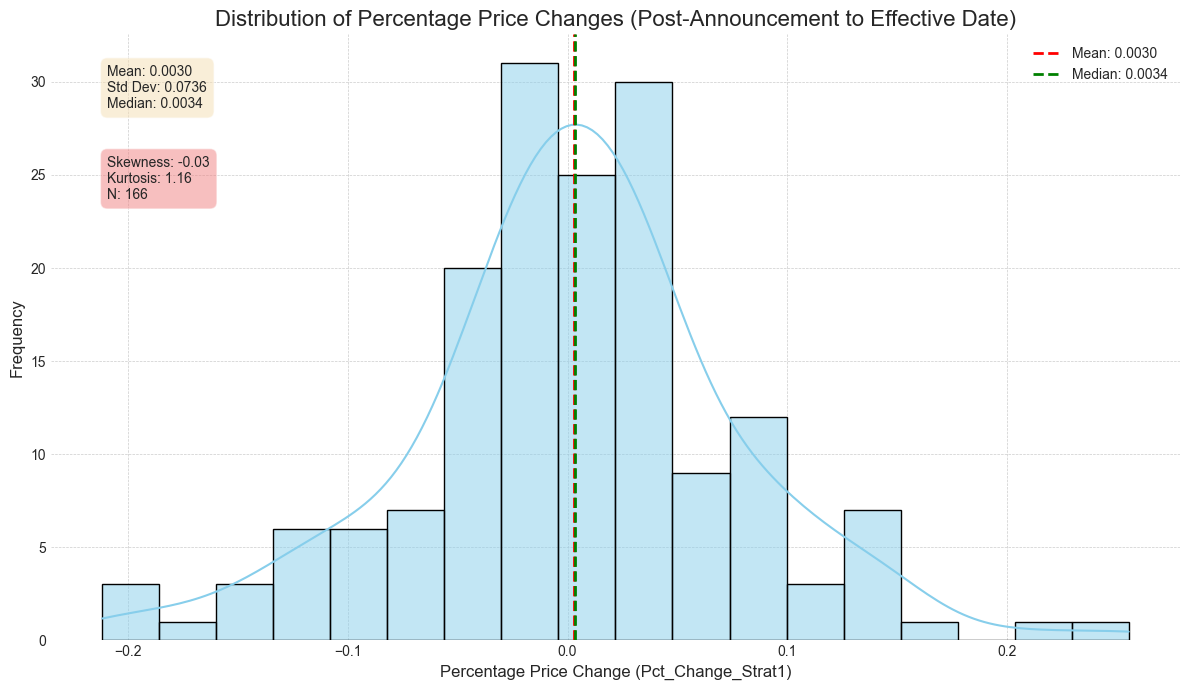


Full Descriptive Statistics for Pct_Change_Strat1:
count    166.000000
mean       0.002982
std        0.073562
min       -0.211686
1%        -0.192573
5%        -0.122282
10%       -0.090947
25%       -0.032892
50%        0.003426
75%        0.039280
90%        0.092827
95%        0.129889
99%        0.171043
max        0.255319
Name: Pct_Change_Strat1, dtype: float64


In [9]:
plot_data = df_events_cleaned['Pct_Change_Strat1'].dropna()

if plot_data.empty:
    print("No valid data available in 'Pct_Change_Strat1' to plot.")
else:
    print(f"Plotting histogram for 'Pct_Change_Strat1' based on {len(plot_data)} data points.")

    # Determine a reasonable number of bins. Freedman-Diaconis rule is often good.
    # Or simply start with a common number like 30-50 and adjust.
    # For simplicity here, let's use a fixed number, e.g., 50, or plt.hist's auto.

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid") # Seaborn style for better aesthetics

    # Histogram using seaborn (which uses matplotlib backend)
    # Using 'kde=True' will add a Kernel Density Estimate plot
    sns.histplot(plot_data, bins='auto', kde=True, color='skyblue', edgecolor='black')

    # Add titles and labels
    plt.title('Distribution of Percentage Price Changes (Post-Announcement to Effective Date)', fontsize=16)
    plt.xlabel('Percentage Price Change (Pct_Change_Strat1)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    # Add a vertical line for the mean
    mean_val = plot_data.mean()
    median_val = plot_data.median()
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.4f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.4f}')

    # Add text annotations for mean and std dev
    std_dev = plot_data.std()
    skewness = plot_data.skew()
    kurt = plot_data.kurtosis() # Fisher's kurtosis (normal is 0)

    plt.text(0.05, 0.95, f'Mean: {mean_val:.4f}\nStd Dev: {std_dev:.4f}\nMedian: {median_val:.4f}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.text(0.05, 0.80, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}\nN: {len(plot_data)}',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='lightcoral', alpha=0.5))


    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    # Additional descriptive statistics that are useful alongside the histogram
    print("\nFull Descriptive Statistics for Pct_Change_Strat1:")
    print(plot_data.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99]))

Calculating Initial Day Return and plotting scatter graph...


C:\Users\evans\AppData\Local\Temp\ipykernel_42376\3464290976.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


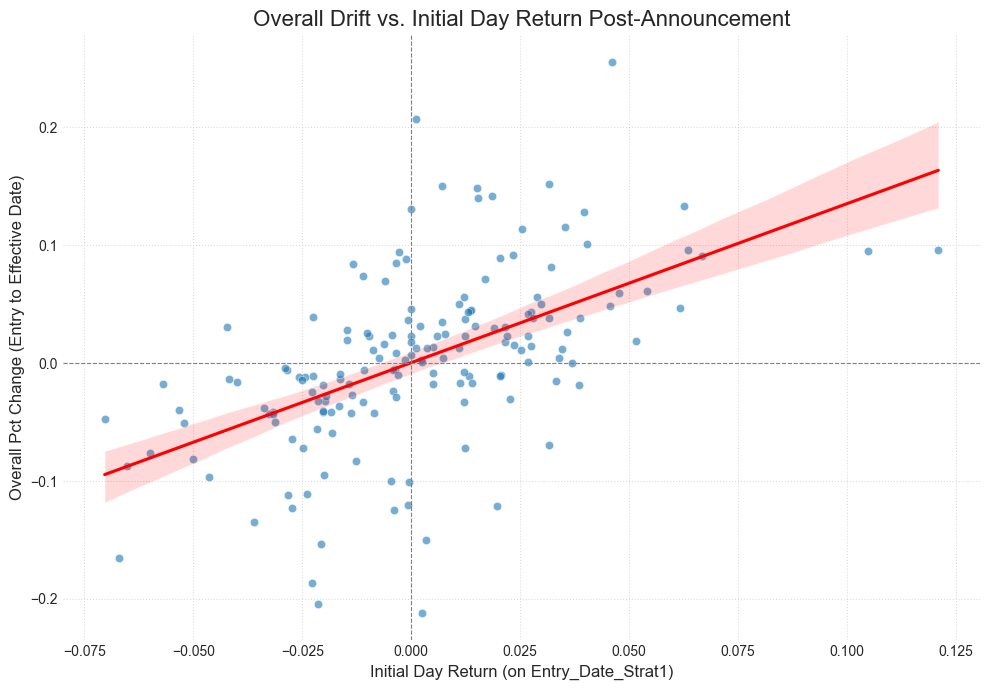


Pearson Correlation between Initial_Day_Return and Pct_Change_Strat1: 0.5463
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.

Descriptive statistics for Initial_Day_Return:
count    166.000000
mean       0.001976
std        0.029795
min       -0.070322
25%       -0.019173
50%        0.000000
75%        0.020559
max        0.120933
Name: Initial_Day_Return, dtype: float64


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

print("Calculating Initial Day Return and plotting scatter graph...")

# Initialize the new column
df_events_cleaned['Initial_Day_Return'] = np.nan
df_events_cleaned['Close_Price_Entry_Date_Strat1'] = np.nan


for index, event_row in df_events_cleaned.iterrows():
    ticker = event_row['Normalized_Ticker']
    entry_date = event_row['Entry_Date_Strat1']
    entry_price_open = event_row['Entry_Price_Strat1'] # This is Open on Entry_Date_Strat1

    if pd.isna(entry_date) or pd.isna(entry_price_open) or entry_price_open == 0:
        continue

    try:
        # Fetch the close price on Entry_Date_Strat1
        if (entry_date, ticker) in stock_price_data_multi.index:
            close_price_entry_date = stock_price_data_multi.loc[(entry_date, ticker), 'Close']
            df_events_cleaned.loc[index, 'Close_Price_Entry_Date_Strat1'] = close_price_entry_date

            if pd.notna(close_price_entry_date):
                initial_day_return = (close_price_entry_date - entry_price_open) / entry_price_open
                df_events_cleaned.loc[index, 'Initial_Day_Return'] = initial_day_return
        else:
            # print(f"Close price not found for {ticker} on {entry_date}. Cannot calculate Initial_Day_Return for event index {index}.")
            pass

    except KeyError:
        # print(f"KeyError for {ticker} on {entry_date} while fetching close price. Event index {index}.")
        continue
    except Exception as e:
        # print(f"Error calculating Initial_Day_Return for {ticker}, event index {index}: {e}")
        continue

# --- Scatter Plot ---
# Drop NaNs for plotting and correlation calculation
plot_df = df_events_cleaned[['Initial_Day_Return', 'Pct_Change_Strat1']].dropna()

if not plot_df.empty:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x='Initial_Day_Return', y='Pct_Change_Strat1', data=plot_df, alpha=0.6)

    # Add a regression line to visualize the trend
    sns.regplot(x='Initial_Day_Return', y='Pct_Change_Strat1', data=plot_df, scatter=False, color='red', line_kws={'label':"Linear Reg."})

    plt.title('Overall Drift vs. Initial Day Return Post-Announcement', fontsize=16)
    plt.xlabel('Initial Day Return (on Entry_Date_Strat1)', fontsize=12)
    plt.ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Calculate Pearson correlation
    correlation, p_value = pearsonr(plot_df['Initial_Day_Return'], plot_df['Pct_Change_Strat1'])
    print(f"\nPearson Correlation between Initial_Day_Return and Pct_Change_Strat1: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("The correlation is statistically significant at the 0.05 level.")
    else:
        print("The correlation is not statistically significant at the 0.05 level.")

    print("\nDescriptive statistics for Initial_Day_Return:")
    print(df_events_cleaned['Initial_Day_Return'].describe())

else:
    print("Not enough data to create scatter plot or calculate correlation after dropping NaNs.")

Calculating Initial N-Day Returns (2-day and 5-day)...


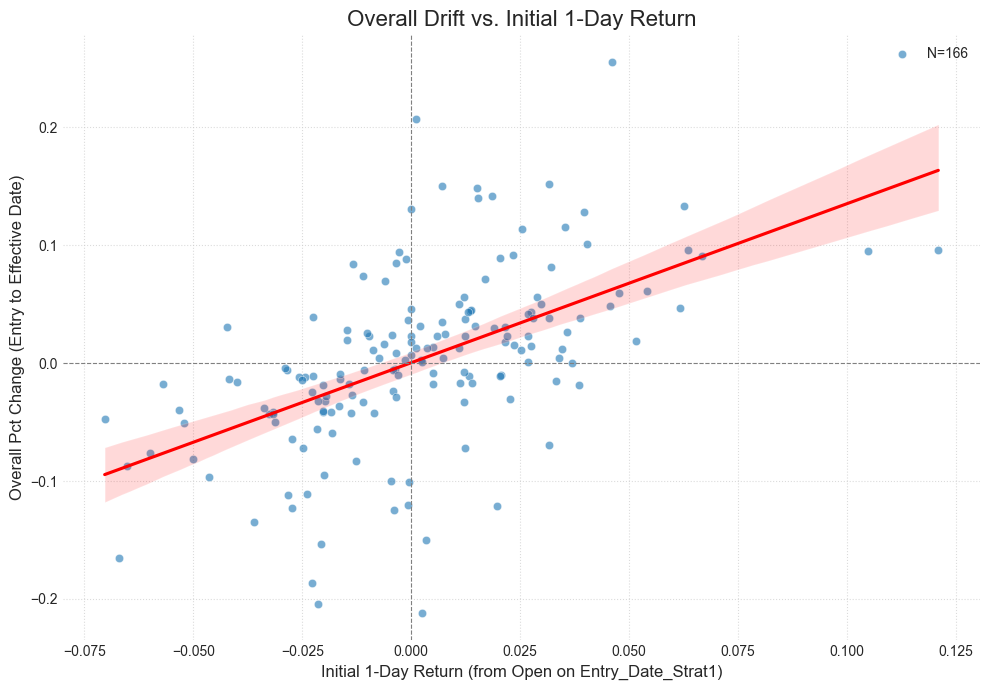


--- Initial 1-Day Return ---
Pearson Correlation with Pct_Change_Strat1: 0.5463
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for this indicator:
count    166.000000
mean       0.001976
std        0.029795
min       -0.070322
25%       -0.019173
50%        0.000000
75%        0.020559
max        0.120933
Name: Initial_Day_Return, dtype: float64


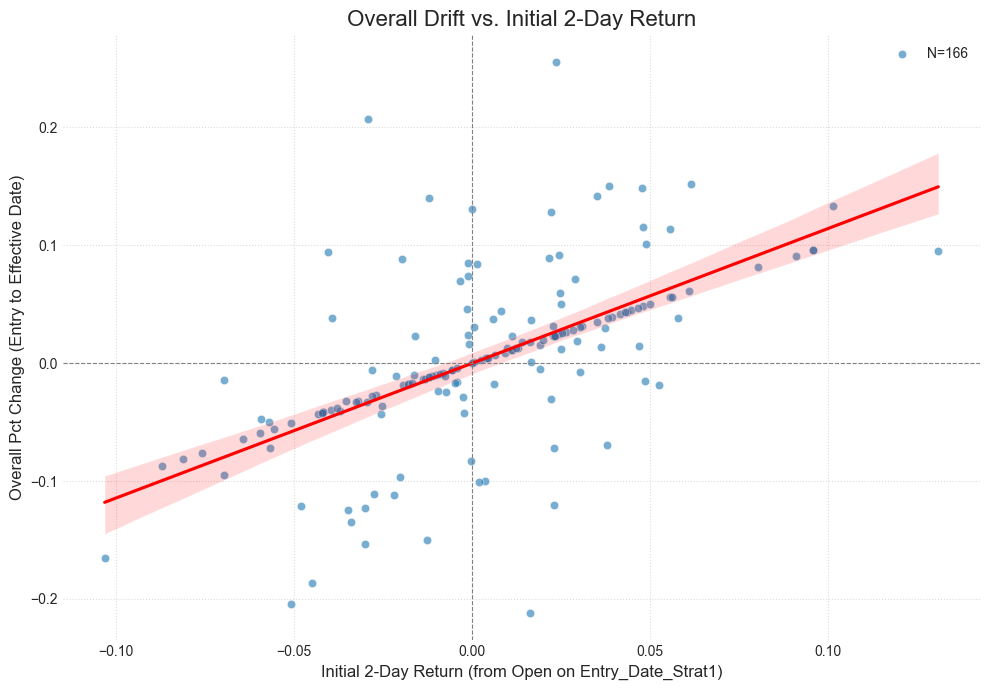


--- Initial 2-Day Return ---
Pearson Correlation with Pct_Change_Strat1: 0.5975
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for this indicator:
count    166.000000
mean       0.002853
std        0.038475
min       -0.103093
25%       -0.021565
50%        0.001125
75%        0.025088
max        0.131103
Name: Initial_2Day_Return, dtype: float64


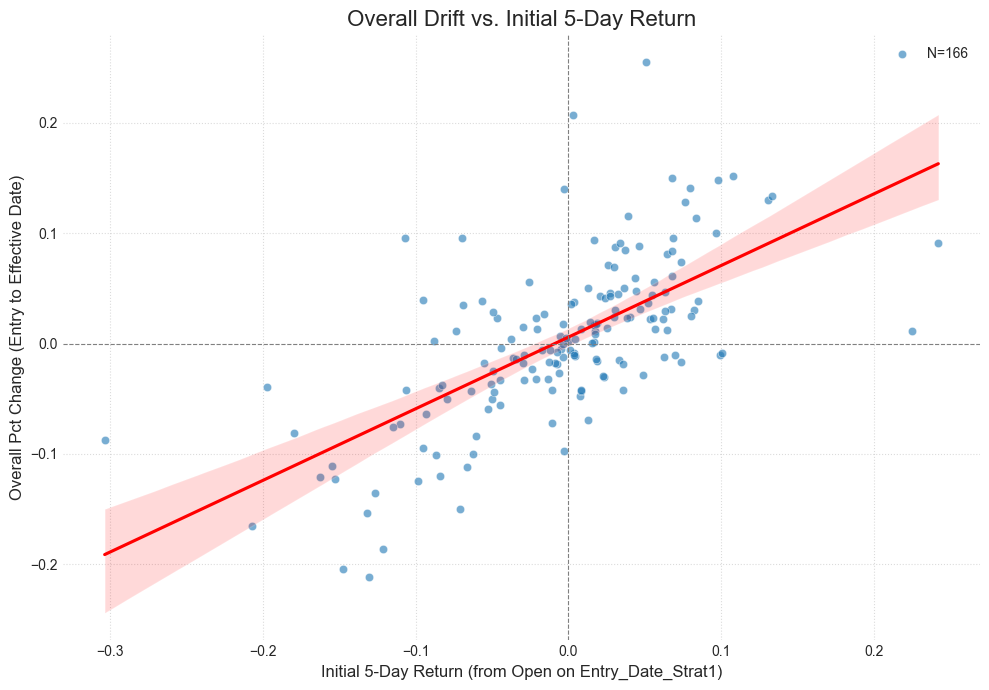


--- Initial 5-Day Return ---
Pearson Correlation with Pct_Change_Strat1: 0.6596
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for this indicator:
count    166.000000
mean      -0.004408
std        0.074733
min       -0.303478
25%       -0.048063
50%        0.004020
75%        0.039884
max        0.242222
Name: Initial_5Day_Return, dtype: float64


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

print("Calculating Initial N-Day Returns (2-day and 5-day)...")

# Initialize new columns
df_events_cleaned['Initial_2Day_Return'] = np.nan
df_events_cleaned['Initial_5Day_Return'] = np.nan

# Helper function to get Nth trading day's close price
def get_nth_day_close(ticker, start_date, n_days, price_data):
    """
    Gets the close price on the Nth trading day *from and including* start_date.
    n_days = 1 means close on start_date.
    n_days = 2 means close on start_date + 1 trading day.
    """
    try:
        # Get all trading days for the ticker on or after start_date
        ticker_prices_after_start = price_data.loc[(slice(start_date, None), ticker), 'Close']
        if len(ticker_prices_after_start) >= n_days:
            return ticker_prices_after_start.iloc[n_days - 1] # 0-indexed
        else:
            return np.nan # Not enough trading days
    except KeyError:
        return np.nan # Ticker or start date not found
    except Exception: # Catch any other indexing error
        return np.nan

for index, event_row in df_events_cleaned.iterrows():
    ticker = event_row['Normalized_Ticker']
    entry_date_strat1 = event_row['Entry_Date_Strat1'] # This is the date of the Open price for momentum calc
    entry_price_open = event_row['Entry_Price_Strat1'] # Open price on Entry_Date_Strat1

    if pd.isna(entry_date_strat1) or pd.isna(entry_price_open) or entry_price_open == 0:
        continue

    # Calculate Initial 2-Day Return
    # (Close on Entry_Date_Strat1 + 1 trading day) / Open on Entry_Date_Strat1 - 1
    close_price_day2 = get_nth_day_close(ticker, entry_date_strat1, 2, stock_price_data_multi)
    if pd.notna(close_price_day2):
        df_events_cleaned.loc[index, 'Initial_2Day_Return'] = (close_price_day2 - entry_price_open) / entry_price_open

    # Calculate Initial 5-Day Return
    # (Close on Entry_Date_Strat1 + 4 trading days) / Open on Entry_Date_Strat1 - 1
    close_price_day5 = get_nth_day_close(ticker, entry_date_strat1, 5, stock_price_data_multi)
    if pd.notna(close_price_day5):
        df_events_cleaned.loc[index, 'Initial_5Day_Return'] = (close_price_day5 - entry_price_open) / entry_price_open

# --- Scatter Plots and Correlations ---
momentum_indicators = {
    'Initial_Day_Return': 'Initial 1-Day Return', # From previous step, assuming column exists
    'Initial_2Day_Return': 'Initial 2-Day Return',
    'Initial_5Day_Return': 'Initial 5-Day Return'
}

if 'Initial_Day_Return' not in df_events_cleaned.columns:
    print("'Initial_Day_Return' column not found. Please ensure previous script was run or uncomment calculation.")
    # Potentially re-run calculation for Initial_Day_Return if needed, or remove from dict

for col_name, plot_label in momentum_indicators.items():
    if col_name not in df_events_cleaned.columns: # Skip if a column wasn't created (e.g. Initial_Day_Return missing)
        print(f"Skipping {plot_label} as column {col_name} is not in DataFrame.")
        continue

    plot_df = df_events_cleaned[[col_name, 'Pct_Change_Strat1']].dropna()

    if not plot_df.empty and len(plot_df) > 1: # Need at least 2 points for correlation
        plt.figure(figsize=(10, 7))
        sns.scatterplot(x=col_name, y='Pct_Change_Strat1', data=plot_df, alpha=0.6, label=f"N={len(plot_df)}")
        sns.regplot(x=col_name, y='Pct_Change_Strat1', data=plot_df, scatter=False, color='red', line_kws={'label':"Linear Reg."})

        plt.title(f'Overall Drift vs. {plot_label}', fontsize=16)
        plt.xlabel(f'{plot_label} (from Open on Entry_Date_Strat1)', fontsize=12)
        plt.ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        plt.show()

        correlation, p_value = pearsonr(plot_df[col_name], plot_df['Pct_Change_Strat1'])
        print(f"\n--- {plot_label} ---")
        print(f"Pearson Correlation with Pct_Change_Strat1: {correlation:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("The correlation is statistically significant at the 0.05 level.")
        else:
            print("The correlation is not statistically significant at the 0.05 level.")
        print(f"Number of valid data points for this analysis: {len(plot_df)}")
        print("Descriptive statistics for this indicator:")
        print(df_events_cleaned[col_name].describe())
    else:
        print(f"\nNot enough data to analyze {plot_label} after dropping NaNs (available: {len(plot_df)}).")

In [12]:
pd.options.display.max_columns = 500
df_events_cleaned

,Announce_Date,Trade_Date,Index,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade,Announced_Date_Orig,Trade_Date_Orig,Ticker_Orig,Normalized_Ticker,ADV to Trade Pct,Entry_Date_Strat1,Entry_Price_Strat1,Exit_Date_Strat1,Exit_Price_Strat1,Pct_Change_Strat1,Abs_Pct_Change_Strat1,Initial_Day_Return,Close_Price_Entry_Date_Strat1,Initial_2Day_Return,Initial_5Day_Return
0,2022-05-12,2022-05-18,S&P 600,AOSL,Add,33.20,Info Tech,2772855.0,92.1,468%,5/12/2022,5/18/2022,AOSL,AOSL,4.68,2022-05-13,38.230000,2022-05-18,39.910000,0.043945,0.043945,0.013602,38.750000,0.008109,0.054669
1,2022-05-12,2022-05-18,S&P 400,IRT,Add,22.44,Real Estate,24230554.0,543.7,689%,5/12/2022,5/18/2022,IRT,IRT,6.89,2022-05-13,19.733495,2022-05-18,19.967451,0.011856,0.011856,0.034656,20.417374,0.025080,0.017328
2,2022-05-12,2022-05-16,S&P 600,DVAX,Add,7.93,Healthcare,14658374.0,116.2,846%,5/12/2022,5/16/2022,DVAX,DVAX,8.46,2022-05-13,9.000000,2022-05-16,9.820000,0.091111,0.091111,0.066667,9.600000,0.091111,0.242222
3,2022-06-03,2022-06-07,S&P 500,VICI,Add,32.45,Real Estate,146440651.0,4752.0,906%,6/3/2022,6/7/2022,VICI,VICI,9.06,2022-06-06,28.641829,2022-06-07,27.445217,-0.041778,0.041778,-0.031632,27.735823,-0.041778,-0.106535
4,2022-06-13,2022-06-15,S&P 600,EYE,Add,39.62,Cons Disc,11230796.0,NaN,1617%,6/13/2022,6/15/2022,EYE,EYE,16.17,2022-06-14,28.299999,2022-06-15,27.799999,-0.017668,0.017668,-0.056890,26.690001,-0.017668,-0.055477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2025-03-26,2025-03-28,S&P 400,CAVA US,Add,86.67,Cons Disc,8961552.0,776.7,223%,3/26/2025,3/28/2025,CAVA US,CAVA,2.23,2025-03-27,89.625000,2025-03-28,85.849998,-0.042120,0.042120,-0.013780,88.389999,-0.042120,0.008089
163,2025-03-26,2025-04-01,S&P 600,ANGI US,Add,16.43,Comm Svcs,886941.0,14.6,454%,3/26/2025,4/1/2025,ANGI US,ANGI,4.54,2025-03-27,16.719999,2025-04-01,14.700000,-0.120813,0.120813,0.019737,17.049999,-0.047847,-0.162679
164,2025-04-09,2025-04-15,S&P 600,ACT US,Add,33.37,Financials,3863743.0,128.9,1536%,4/9/2025,4/15/2025,ACT US,ACT,15.36,2025-04-10,35.435898,2025-04-15,35.058071,-0.010662,0.010662,-0.022447,34.640480,-0.007576,-0.029181
165,2025-04-14,2025-04-16,S&P 600,STRL US,Add,135.23,Industrials,4004975.0,541.6,528%,4/14/2025,4/16/2025,STRL US,STRL,5.28,2025-04-15,145.940002,2025-04-16,140.440002,-0.037687,0.037687,-0.033850,141.000000,-0.037687,-0.082363


Calculating evolving correlation of 1-day test returns with overall drift...


C:\Users\evans\AppData\Local\Temp\ipykernel_42376\43368765.py:32: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  lambda x: x.pct_change()


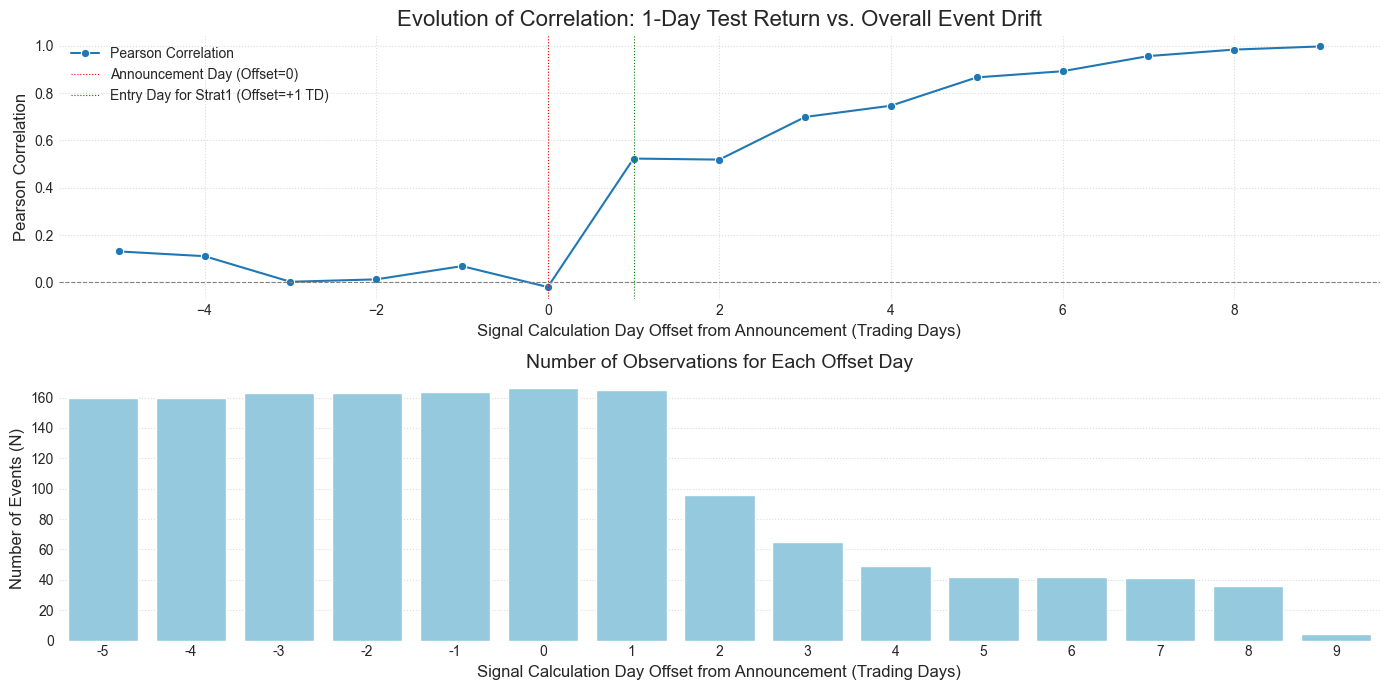


Correlation Results by Offset Day:
    Offset_Days  Correlation       P_Value  N_Observations
0            -5     0.130694  9.950071e-02             160
1            -4     0.110641  1.636755e-01             160
2            -3     0.002429  9.754469e-01             163
3            -2     0.012658  8.725900e-01             163
4            -1     0.068667  3.822964e-01             164
5             0    -0.019701  8.010897e-01             166
6             1     0.523156  5.638522e-13             165
7             2     0.518714  6.167288e-08              96
8             3     0.698930  9.504470e-11              65
9             4     0.746546  7.355576e-10              49
10            5     0.866076  1.297216e-13              42
11            6     0.892208  2.168789e-15              42
12            7     0.956199  2.058536e-22              41
13            8     0.983622  6.899922e-27              36
14            9     0.996880  3.119879e-03               4


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pandas.tseries.offsets import BDay # Business Day offset


print("Calculating evolving correlation of 1-day test returns with overall drift...")

# Define the range of offsets from Announce_Date (in TRADING DAYS)
# Negative offsets are days before announcement, positive are after.
# Offset 0 would be the Announce_Date itself.
# Offset +1 would be the first trading day after Announce_Date.
day_offsets = list(range(-5, 11)) # From 5 trading days before to 10 trading days after

correlations = []
p_values = []
num_observations = []
actual_offsets_used = [] # To store the offset if calculation was possible

# Ensure stock_price_data_multi has 'Close' and is sorted
stock_price_data_multi.sort_index(inplace=True)

# Pre-calculate 1-day returns for all stocks to speed up lookups
# Using 'Adj Close' is often preferred for returns to handle splits/dividends,
# but the project implies using Open/Close. Let's stick to 'Close' for consistency with prev steps unless specified.
# If 'Adj Close' is available and reliable, it's generally better for return calculations over time.
# For this, let's use 'Close' as per previous work.
if 'Daily_Return' not in stock_price_data_multi.columns:
    stock_price_data_multi['Daily_Return'] = stock_price_data_multi.groupby(level='Ticker')['Close'].transform(
        lambda x: x.pct_change()
    )

for offset_days in day_offsets:
    test_returns_for_offset = []
    target_returns_for_offset = [] # Pct_Change_Strat1 for corresponding events

    for index, event_row in df_events_cleaned.iterrows():
        ticker = event_row['Normalized_Ticker']
        announce_date = event_row['Announce_Date']
        entry_price_strat1 = event_row['Entry_Price_Strat1']
        pct_change_strat1 = event_row['Pct_Change_Strat1']
        effective_date = event_row['Trade_Date']
        entry_date_strat1 = event_row['Entry_Date_Strat1'] # Day after announce date

        if pd.isna(pct_change_strat1):
            continue

        # Determine the actual "Signal Calculation Day"
        # This requires finding the Nth business day from announce_date
        # We need to find the trading day that corresponds to Announce_Date + offset_days

        # Get all trading days for the ticker
        try:
            ticker_trading_days = stock_price_data_multi.loc[(slice(None), ticker), :].index.get_level_values('Date').unique().sort_values()
        except KeyError:
            continue # Ticker not in price data

        if ticker_trading_days.empty:
            continue

        # Find Announce_Date's position or closest if not a trading day
        # For simplicity, let's assume Announce_Date itself IS a trading day, or we align to it.
        # A robust way: find the index of Announce_Date, then add offset.
        try:
            # Find the trading day on or immediately after Announce_Date
            actual_announce_td = ticker_trading_days[ticker_trading_days >= announce_date][0]
            announce_date_idx_in_ticker_days = ticker_trading_days.get_loc(actual_announce_td)
        except (IndexError, KeyError): # Announce_Date is after last trading day for ticker, or other issue
            continue

        signal_calc_day_idx = announce_date_idx_in_ticker_days + offset_days

        if 0 <= signal_calc_day_idx < len(ticker_trading_days):
            signal_calc_day = ticker_trading_days[signal_calc_day_idx]

            # Ensure signal_calc_day is before the period of Pct_Change_Strat1 starts
            # Pct_Change_Strat1 starts effectively on entry_date_strat1.
            # And also ensure signal_calc_day is not too close to or after effective_date
            if signal_calc_day >= entry_date_strat1 and offset_days < 1: # Test return should not overlap/be after start of target return period unless offset is positive
                 # If offset_days is 0 or negative, signal_calc_day should be <= announce_date.
                 # entry_date_strat1 is announce_date + 1BD (approx).
                 # So if signal_calc_day is on or after entry_date_strat1 for negative/zero offsets, there's an issue.
                 # This check might be too strict or needs refinement based on exact definitions.
                 # Let's assume for now that we want the signal day to be distinct and generally prior or at start.
                 pass # Allow positive offsets to be within the Pct_Change_Strat1 window

            if signal_calc_day >= effective_date: # Signal calc day should not be after the target period ends
                continue

            # Get the 1-day test return ending on signal_calc_day
            try:
                test_return = (stock_price_data_multi.loc[(signal_calc_day, ticker), 'Close'] - entry_price_strat1)/entry_price_strat1
                if pd.notna(test_return):
                    test_returns_for_offset.append(test_return)
                    target_returns_for_offset.append(pct_change_strat1)
            except KeyError:
                continue # Data not available for this specific day/ticker
        else:
            # Offset leads to a date outside the ticker's trading history
            continue

    if len(test_returns_for_offset) > 1: # Need at least 2 pairs for correlation
        corr, p_val = pearsonr(test_returns_for_offset, target_returns_for_offset)
        correlations.append(corr)
        p_values.append(p_val)
        num_observations.append(len(test_returns_for_offset))
        actual_offsets_used.append(offset_days)
    else:
        # Not enough data for this offset
        # To keep plot x-axis consistent, we can append NaN or skip
        pass # The actual_offsets_used will reflect which ones we got data for

# --- Plotting the results ---
if actual_offsets_used:
    results_df = pd.DataFrame({
        'Offset_Days': actual_offsets_used,
        'Correlation': correlations,
        'P_Value': p_values,
        'N_Observations': num_observations
    })

    plt.figure(figsize=(14, 7))

    # Plot Correlation
    plt.subplot(2, 1, 1)
    sns.lineplot(x='Offset_Days', y='Correlation', data=results_df, marker='o', label='Pearson Correlation')
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.axvline(0, color='red', linestyle=':', linewidth=0.8, label='Announcement Day (Offset=0)')
    plt.axvline(1, color='green', linestyle=':', linewidth=0.8, label='Entry Day for Strat1 (Offset=+1 TD)')
    plt.title('Evolution of Correlation: 1-Day Test Return vs. Overall Event Drift', fontsize=16)
    plt.xlabel('Signal Calculation Day Offset from Announcement (Trading Days)', fontsize=12)
    plt.ylabel('Pearson Correlation', fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()

    # Plot Number of Observations
    plt.subplot(2, 1, 2)
    sns.barplot(x='Offset_Days', y='N_Observations', data=results_df, color='skyblue')
    plt.title('Number of Observations for Each Offset Day', fontsize=14)
    plt.xlabel('Signal Calculation Day Offset from Announcement (Trading Days)', fontsize=12)
    plt.ylabel('Number of Events (N)', fontsize=12)
    plt.grid(True, axis='y', linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

    print("\nCorrelation Results by Offset Day:")
    print(results_df)
else:
    print("No correlation data generated. Check data availability or offset range.")

might wanna check how signal changes over time

Calculating Total_Event_Trading_Days for each event...

Distribution of Total_Event_Trading_Days:
count    167.000000
mean       5.245509
std        2.848519
min        2.000000
25%        3.000000
50%        4.000000
75%        7.000000
max       11.000000
Name: Total_Event_Trading_Days, dtype: float64

Value Counts for Total_Event_Trading_Days:
Total_Event_Trading_Days
2.0      1
3.0     69
4.0     32
5.0     16
6.0      7
8.0      1
9.0      5
10.0    32
11.0     4
Name: count, dtype: int64


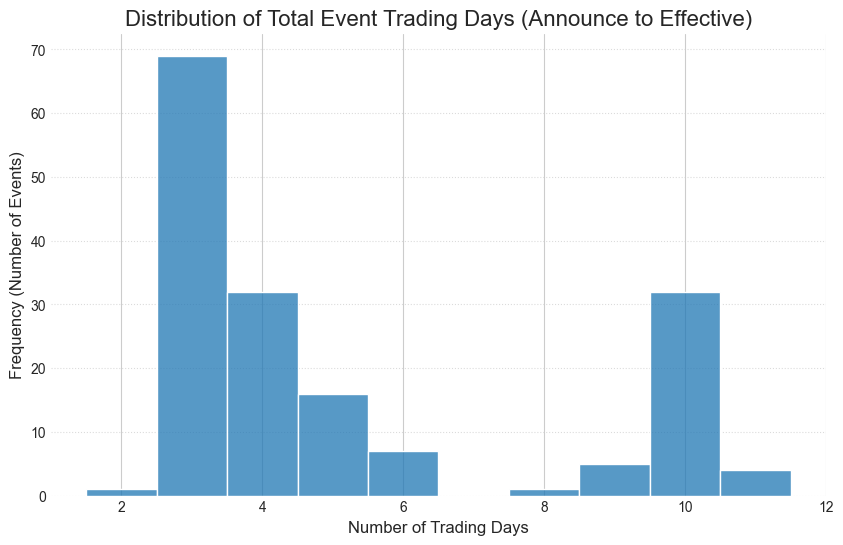

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pandas.tseries.offsets import BDay


print("Calculating Total_Event_Trading_Days for each event...")

df_events_cleaned['Total_Event_Trading_Days'] = np.nan

for index, event_row in df_events_cleaned.iterrows():
    ticker = event_row['Normalized_Ticker']
    announce_date = event_row['Announce_Date']
    effective_date = event_row['Trade_Date']

    try:
        # Get trading days for this ticker between announce and effective (inclusive for count)
        ticker_event_period_prices = stock_price_data_multi.loc[(slice(announce_date, effective_date), ticker), :]
        if not ticker_event_period_prices.empty:
            # Number of unique trading days in the interval
            num_trading_days = ticker_event_period_prices.index.get_level_values('Date').nunique()
            df_events_cleaned.loc[index, 'Total_Event_Trading_Days'] = num_trading_days
    except KeyError:
        # Ticker or part of date range not in price data
        # print(f"Price data missing for {ticker} between {announce_date} and {effective_date}")
        pass
    except Exception as e:
        # print(f"Error calculating trading days for event index {index}: {e}")
        pass

# --- Analyze the distribution of Total_Event_Trading_Days ---
print("\nDistribution of Total_Event_Trading_Days:")
print(df_events_cleaned['Total_Event_Trading_Days'].describe())
print("\nValue Counts for Total_Event_Trading_Days:")
print(df_events_cleaned['Total_Event_Trading_Days'].value_counts().sort_index())

# Plot distribution of Total_Event_Trading_Days
plt.figure(figsize=(10, 6))
sns.histplot(df_events_cleaned['Total_Event_Trading_Days'].dropna(), discrete=True, kde=False)
plt.title('Distribution of Total Event Trading Days (Announce to Effective)', fontsize=16)
plt.xlabel('Number of Trading Days', fontsize=12)
plt.ylabel('Frequency (Number of Events)', fontsize=12)
plt.grid(True, axis='y', linestyle=':', alpha=0.7)
plt.show()

Generating evolving correlation plots for grouped Total_Event_Trading_Days...

--- Analyzing for Group: Short (2-6 days) ---
tickerAOSL
Price                   Open   High        Low      Close     Volume  \
Date       Ticker                                                      
2022-05-12 AOSL    32.150002  34.16  31.650000  33.200001   587500.0   
2022-05-13 AOSL    38.230000  40.98  37.450001  38.750000  2296400.0   
2022-05-16 AOSL    38.509998  39.84  38.009998  38.540001   936000.0   
2022-05-17 AOSL    40.509998  41.68  39.570000  40.580002  1152200.0   
2022-05-18 AOSL    39.450001  41.77  39.290001  39.910000  5137100.0   

Price                ADV_20  Daily_Return  
Date       Ticker                          
2022-05-12 AOSL    492680.0      0.016845  
2022-05-13 AOSL    496105.0      0.167169  
2022-05-16 AOSL    594405.0     -0.005419  
2022-05-17 AOSL    620870.0      0.052932  
2022-05-18 AOSL    665095.0     -0.016511  
price on signal day33.20000076293945
price on first

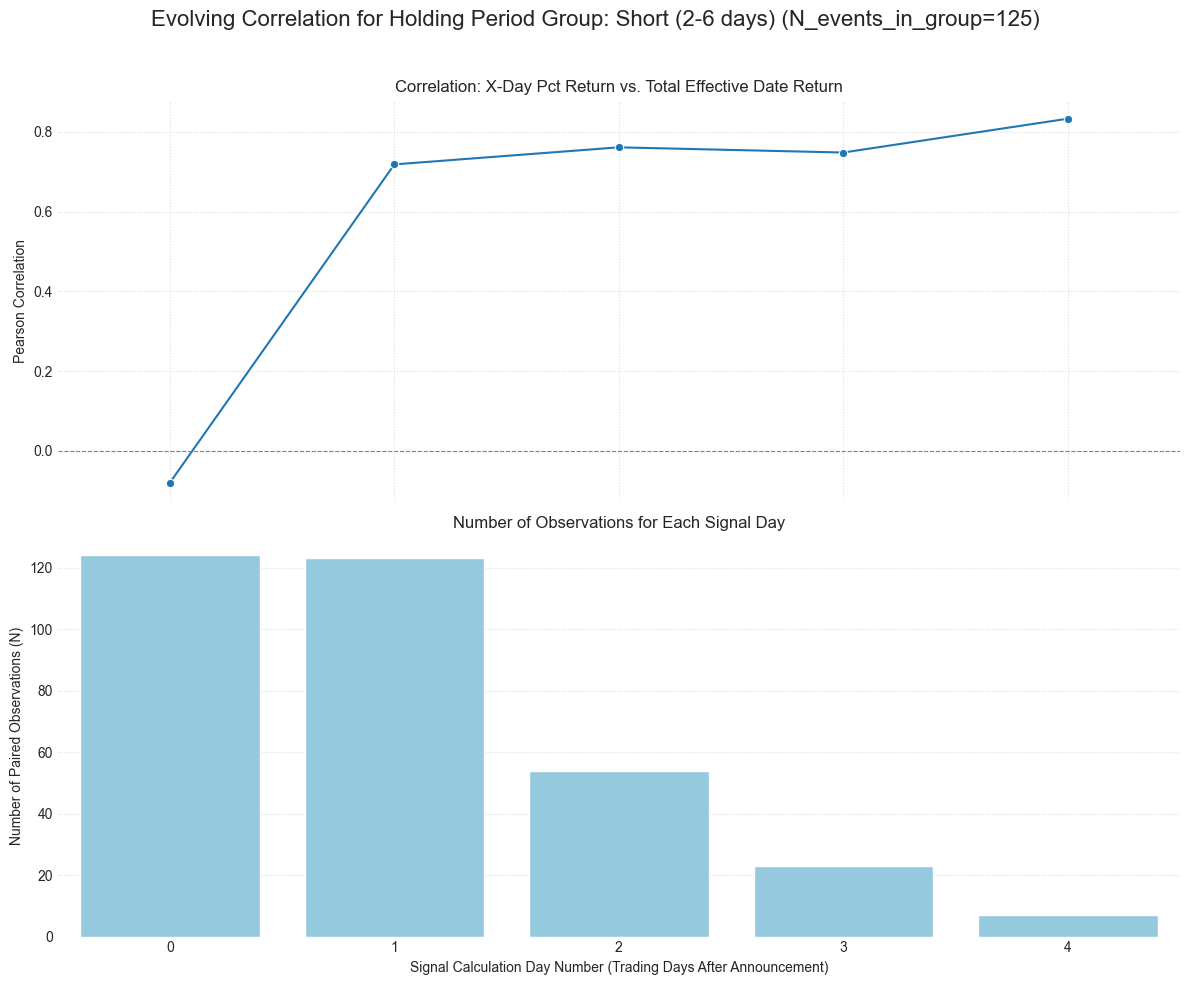

Correlation Results for Group: Short (2-6 days):
   Signal_Day_Num_Post_Announce  Correlation       P_Value  N_Observations
0                             0    -0.080006  3.770700e-01             124
1                             1     0.718333  8.572105e-21             123
2                             2     0.761137  2.383419e-11              54
3                             3     0.748122  4.048976e-05              23
4                             4     0.832961  1.997493e-02               7

--- Analyzing for Group: Long (8-11 days) ---
tickerCSGP
Price                   Open       High        Low      Close      Volume  \
Date       Ticker                                                           
2022-09-06 CSGP    75.000000  76.919998  74.690002  76.199997   9180200.0   
2022-09-07 CSGP    75.680000  78.349998  75.419998  78.070000   4329000.0   
2022-09-08 CSGP    77.239998  79.260002  77.040001  78.559998   3213100.0   
2022-09-09 CSGP    78.410004  79.139999  77.830002  78.419

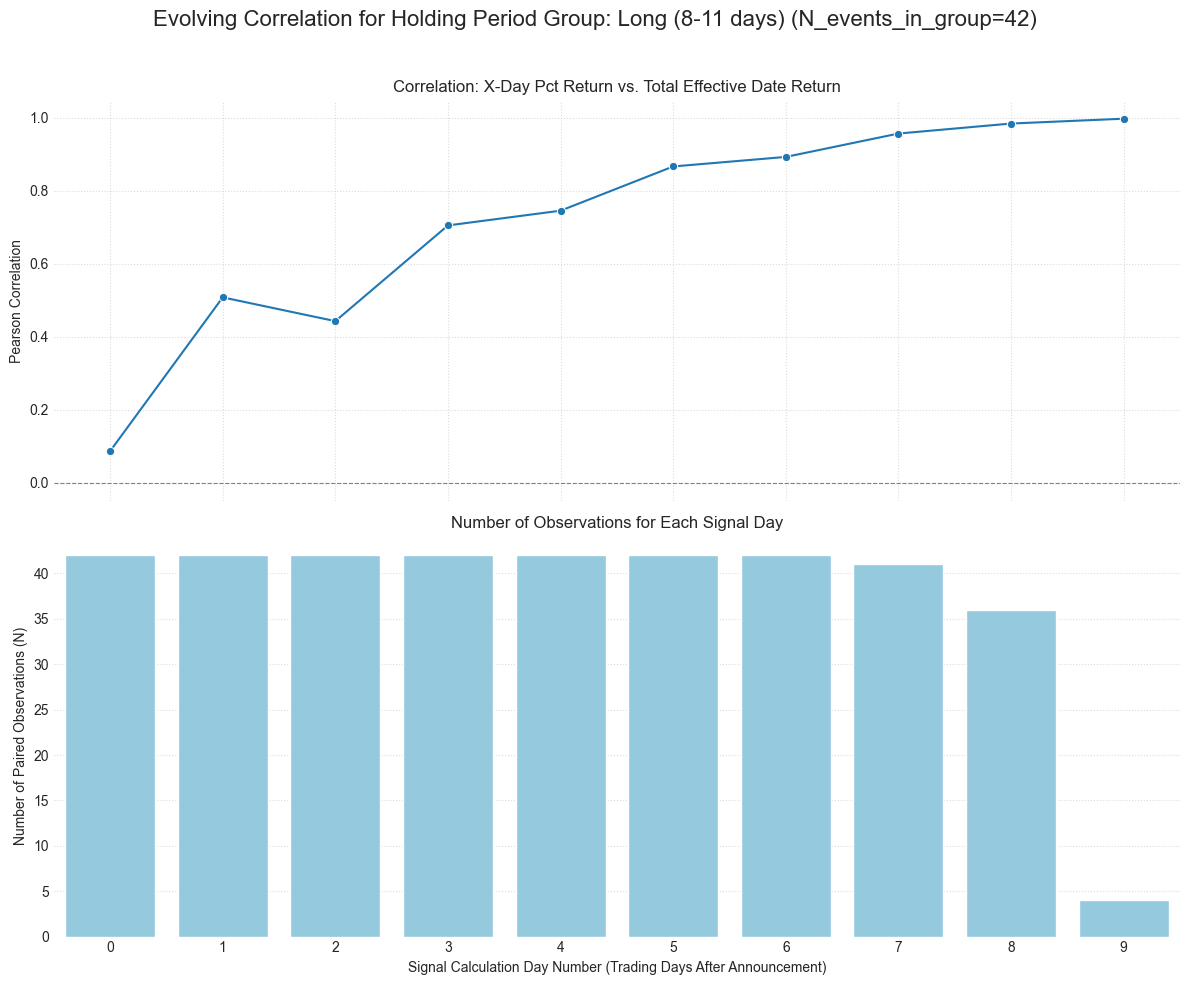

Correlation Results for Group: Long (8-11 days):
   Signal_Day_Num_Post_Announce  Correlation       P_Value  N_Observations
0                             0     0.086293  5.868685e-01              42
1                             1     0.507512  6.023482e-04              42
2                             2     0.442375  3.352675e-03              42
3                             3     0.704553  1.914863e-07              42
4                             4     0.744928  1.537950e-08              42
5                             5     0.866076  1.297216e-13              42
6                             6     0.892208  2.168789e-15              42
7                             7     0.956199  2.058536e-22              41
8                             8     0.983622  6.899922e-27              36
9                             9     0.996880  3.119879e-03               4


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from pandas.tseries.offsets import BDay

print("Generating evolving correlation plots for grouped Total_Event_Trading_Days...")

# Define the groups based on Total_Event_Trading_Days
holding_period_groups = {
    "Short (2-6 days)": (2.0, 6.0),
    "Long (8-11 days)": (8.0, 11.0)
}

# Ensure stock_price_data_multi has 'Close' and 'Daily_Return' and is sorted
stock_price_data_multi.sort_index(inplace=True)

for group_name, (min_days, max_days) in holding_period_groups.items():
    print(f"\n--- Analyzing for Group: {group_name} ---")

    # Filter events for this specific group
    group_events_df = df_events_cleaned[
        (df_events_cleaned['Total_Event_Trading_Days'] >= min_days) &
        (df_events_cleaned['Total_Event_Trading_Days'] <= max_days)
    ].copy()

    if group_events_df.empty:
        print(f"No events found for group: {group_name}.")
        continue

    # Determine the maximum signal offset to consider for this group.
    # This should be based on the shortest event in the group to ensure comparability,
    # or we can allow the x-axis to extend as far as the longest event in the group allows.
    # Let's allow it to extend, and N will drop for shorter events within the group.
    # Max possible offset is max_days_in_group - 2.
    # We can analyze up to, say, 10 post-announcement trading days if data allows.
    max_post_announce_offset_to_test = int(max_days) - 2 # Ensure at least 1 day for remaining drift for longest event in group
                                                        # And signal day is 1 day after announce_date (index 0)

    # Define the range of signal calculation days (number of trading days after Announce_Date)
    # Offset_PATD1 = 0 -> 1st trading day after Announce_Date
    # Offset_PATD1 = 1 -> 2nd trading day after Announce_Date
    # ...
    # Max offset_patd1 is such that Signal_Calc_Day_T is one day before Effective_Date of the *shortest* event
    # For a group, let's test up to a reasonable max, e.g., 9, and let N handle availability.
    # If max_days is 11, max_offset_patd1 is 11-2 = 9. (Signal on 10th day post announce, drift on 11th day)

    post_announce_offsets = list(range(0, int(max_days) - 1)) # from 0 up to max_days-2 (inclusive for offset_patd1)

    correlations_group = []
    p_values_group = []
    num_observations_group = []
    actual_offsets_plot = [] # The Signal_Day_Num_Post_Announce (offset_patd1 + 1)

    for offset_patd1 in post_announce_offsets: # 0 means 1st day after announce, 1 means 2nd, etc.
        test_returns_for_offset = []
        target_returns_for_offset = []

        current_signal_day_num = offset_patd1 # Day 1, Day 2, ... post announcement

        for index, event_row in group_events_df.iterrows():
            ticker = event_row['Normalized_Ticker']
            announce_date = event_row['Announce_Date']
            effective_date = event_row['Trade_Date']
            event_total_days = event_row['Total_Event_Trading_Days']
            pct_change_strat1 = event_row['Pct_Change_Strat1']
            exit_price_strat1 = event_row['Exit_Price_Strat1']
            entry_price_strat1 = event_row['Entry_Price_Strat1']


            # Ensure this event is long enough for the current offset_patd1
            if current_signal_day_num >= event_total_days: # Signal day must be < total days (i.e. before effective date)
                continue

            try:
                ticker_trading_days = stock_price_data_multi.loc[(slice(None), ticker), :].index.get_level_values('Date').unique().sort_values()
                actual_announce_td_idx = ticker_trading_days.get_loc(ticker_trading_days[ticker_trading_days >= announce_date][0])
            except (KeyError, IndexError): continue

            signal_calc_day_idx = actual_announce_td_idx + current_signal_day_num # current_signal_day_num is offset_patd1 + 1

            if not (0 <= signal_calc_day_idx < len(ticker_trading_days)): continue
            signal_calc_day_t = ticker_trading_days[signal_calc_day_idx]

            if signal_calc_day_t >= effective_date: continue # Should be caught by above check too

            #test_return = stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Daily_Return']
            test_return = (stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Close'] - entry_price_strat1)/entry_price_strat1
            print("ticker" + str(ticker))
            print(stock_price_data_multi.loc[(slice(announce_date, effective_date), ticker), :]) #slice(announce_date + pd.Timedelta(days=1), None)
            print("price on signal day" + str(stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Close']))
            print("price on first day" + str(entry_price_strat1))
            print("test return is" + str(test_return))
            close_signal_calc_day_t = stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Close']

            try:
                actual_effective_date_td = ticker_trading_days[ticker_trading_days <= effective_date][-1]
                if actual_effective_date_td <= signal_calc_day_t: continue
                close_effective_date = stock_price_data_multi.loc[(actual_effective_date_td, ticker), 'Close']
            except (KeyError, IndexError): continue

            if pd.notna(test_return) and pd.notna(close_signal_calc_day_t) and close_signal_calc_day_t != 0 and pd.notna(close_effective_date):
                remaining_drift = (exit_price_strat1 - stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Close'])/stock_price_data_multi.loc[(signal_calc_day_t, ticker), 'Close']
                test_returns_for_offset.append(test_return)
                print(test_return)
                target_returns_for_offset.append(pct_change_strat1)
                print(pct_change_strat1)

        if len(test_returns_for_offset) > 1:
            corr, p_val = pearsonr(test_returns_for_offset, target_returns_for_offset)
            correlations_group.append(corr)
            p_values_group.append(p_val)
            num_observations_group.append(len(test_returns_for_offset))
            actual_offsets_plot.append(current_signal_day_num)

    if actual_offsets_plot:
        group_results_df = pd.DataFrame({
            'Signal_Day_Num_Post_Announce': actual_offsets_plot,
            'Correlation': correlations_group,
            'P_Value': p_values_group,
            'N_Observations': num_observations_group
        })

        fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        fig.suptitle(f'Evolving Correlation for Holding Period Group: {group_name} (N_events_in_group={len(group_events_df)})', fontsize=16)

        sns.lineplot(x='Signal_Day_Num_Post_Announce', y='Correlation', data=group_results_df, marker='o', ax=axes[0])
        axes[0].axhline(0, color='grey', linestyle='--', linewidth=0.8)
        axes[0].set_title('Correlation: X-Day Pct Return vs. Total Effective Date Return')
        axes[0].set_ylabel('Pearson Correlation')
        axes[0].grid(True, linestyle=':', alpha=0.7)

        sns.barplot(x='Signal_Day_Num_Post_Announce', y='N_Observations', data=group_results_df, color='skyblue', ax=axes[1])
        axes[1].set_title('Number of Observations for Each Signal Day')
        axes[1].set_xlabel('Signal Calculation Day Number (Trading Days After Announcement)')
        axes[1].set_ylabel('Number of Paired Observations (N)')
        axes[1].grid(True, axis='y', linestyle=':', alpha=0.7)

        plt.xticks(np.unique(actual_offsets_plot)) # Ensure all actual offset days are shown as ticks
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        print(f"Correlation Results for Group: {group_name}:")
        print(group_results_df)
    else:
        print(f"No correlation data generated for group: {group_name}.")

C:\Users\evans\AppData\Local\Temp\ipykernel_42376\3127094487.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


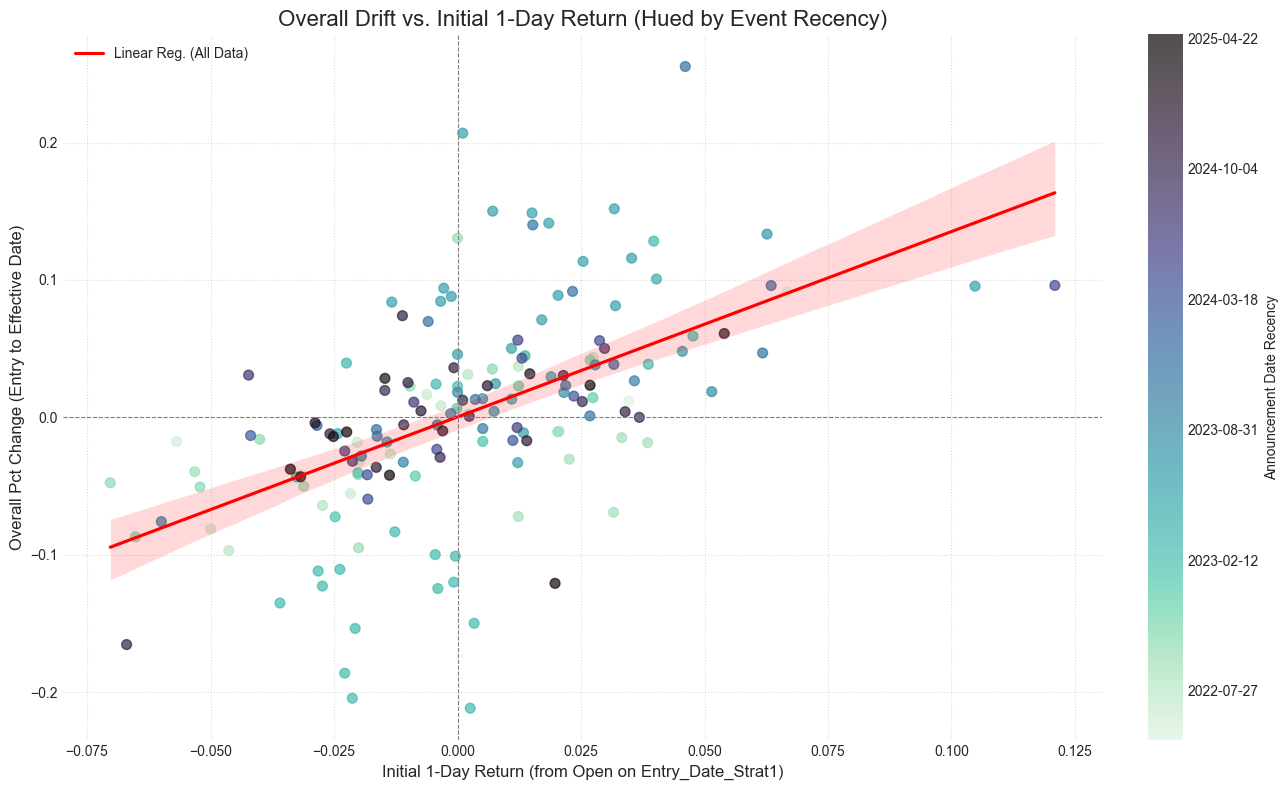

C:\Users\evans\AppData\Local\Temp\ipykernel_42376\3127094487.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])



--- Initial 1-Day Return (Overall Correlation) ---
Pearson Correlation with Pct_Change_Strat1: 0.5463
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for Initial_Day_Return (plotted data):
count    166.000000
mean       0.001976
std        0.029795
min       -0.070322
25%       -0.019173
50%        0.000000
75%        0.020559
max        0.120933
Name: Initial_Day_Return, dtype: float64


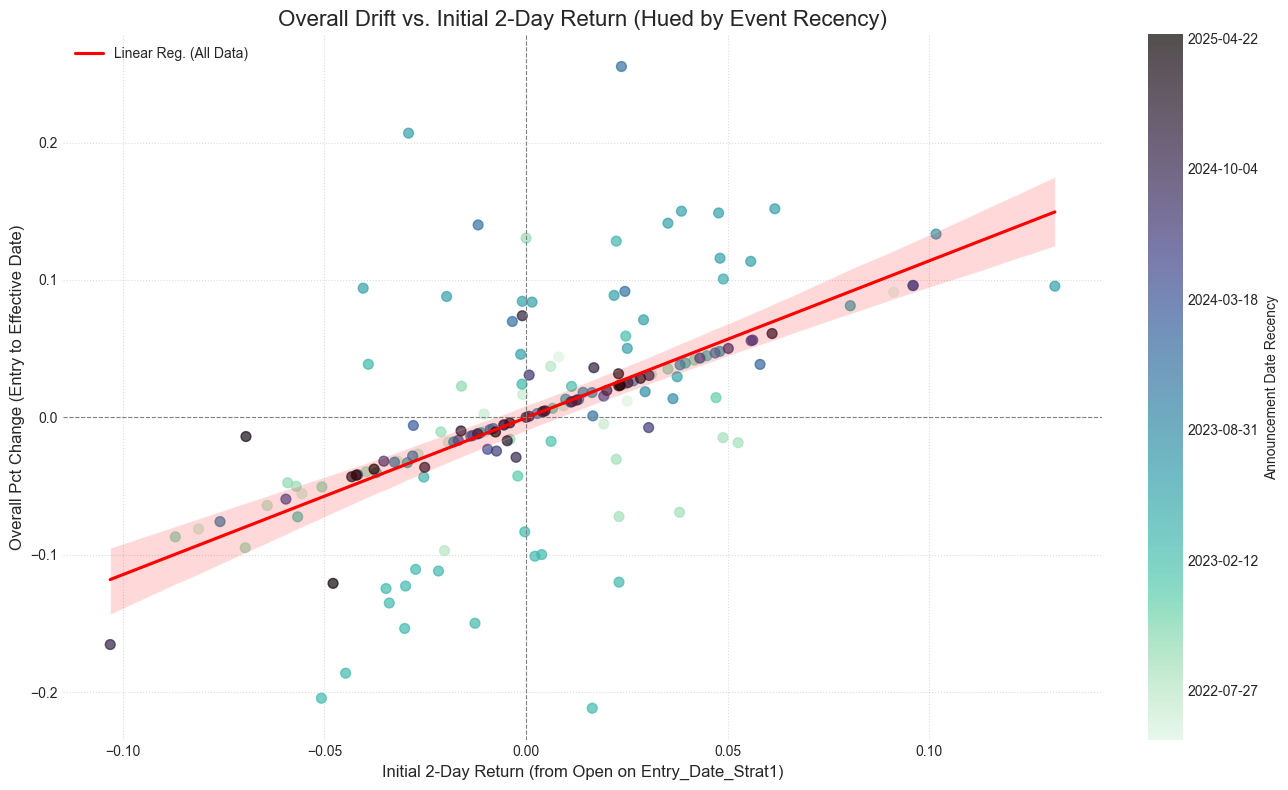


--- Initial 2-Day Return (Overall Correlation) ---
Pearson Correlation with Pct_Change_Strat1: 0.5975
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for Initial_2Day_Return (plotted data):
count    166.000000
mean       0.002853
std        0.038475
min       -0.103093
25%       -0.021565
50%        0.001125
75%        0.025088
max        0.131103
Name: Initial_2Day_Return, dtype: float64


C:\Users\evans\AppData\Local\Temp\ipykernel_42376\3127094487.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


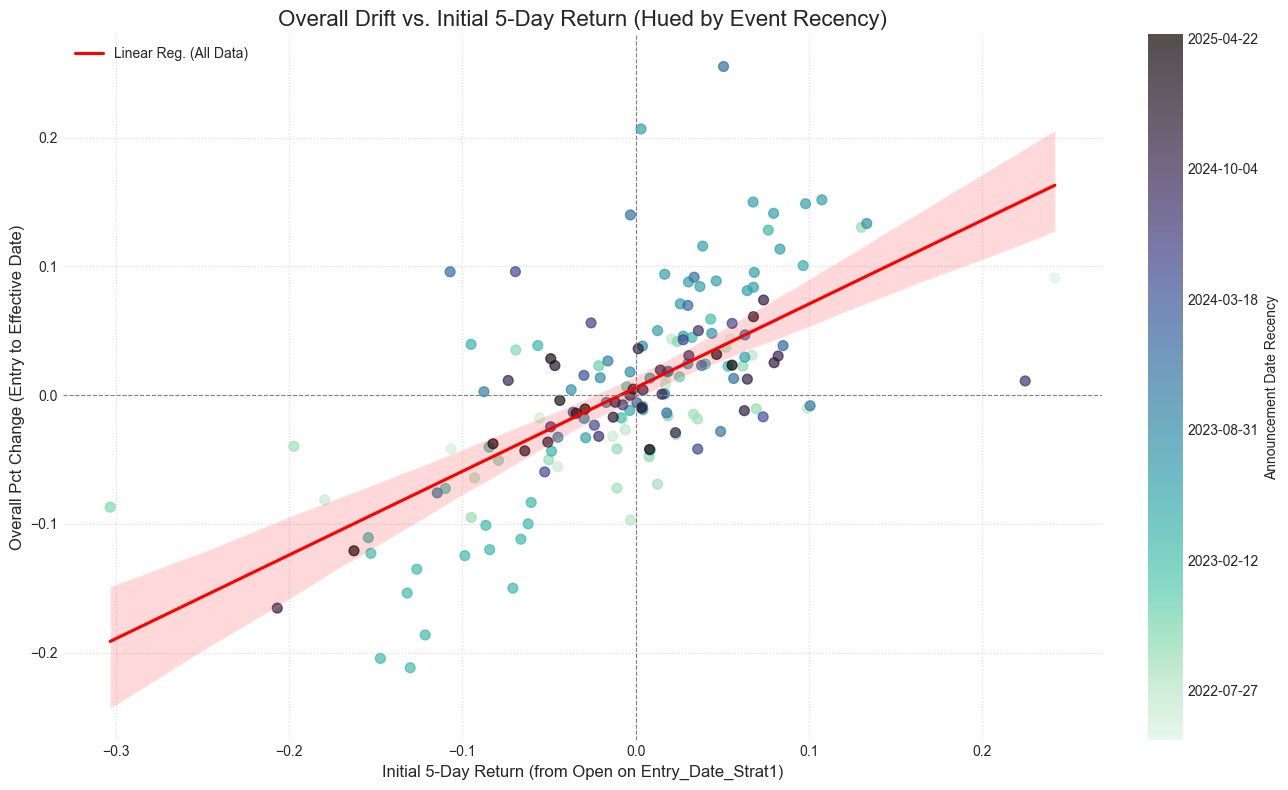


--- Initial 5-Day Return (Overall Correlation) ---
Pearson Correlation with Pct_Change_Strat1: 0.6596
P-value: 0.0000
The correlation is statistically significant at the 0.05 level.
Number of valid data points for this analysis: 166
Descriptive statistics for Initial_5Day_Return (plotted data):
count    166.000000
mean      -0.004408
std        0.074733
min       -0.303478
25%       -0.048063
50%        0.004020
75%        0.039884
max        0.242222
Name: Initial_5Day_Return, dtype: float64


In [ ]:
import matplotlib.dates as mdates # For date formatting on colorbar


momentum_indicators = {
    'Initial_Day_Return': 'Initial 1-Day Return',
    'Initial_2Day_Return': 'Initial 2-Day Return',
    'Initial_5Day_Return': 'Initial 5-Day Return'
}

df_events_cleaned['Announce_Date'] = pd.to_datetime(df_events_cleaned['Announce_Date'])

for col_name, plot_label in momentum_indicators.items():
    if col_name not in df_events_cleaned.columns:
        print(f"Skipping {plot_label} as column {col_name} is not in DataFrame.")
        continue

    required_cols_for_plot = [col_name, 'Pct_Change_Strat1', 'Announce_Date']
    if not all(c in df_events_cleaned.columns for c in required_cols_for_plot):
        print(f"Skipping {plot_label} due to missing one of required columns: {required_cols_for_plot}")
        continue

    plot_df = df_events_cleaned[required_cols_for_plot].dropna().copy() # Use .copy() to avoid SettingWithCopyWarning

    # Convert Announce_Date to a numerical representation for hue
    # Using to_julian_date() which gives a float, or .map(pd.Timestamp.toordinal) for integer ordinals
    # Matplotlib's mdates.date2num also works well.
    plot_df['Announce_Date_Num'] = plot_df['Announce_Date'].map(mdates.date2num)


    if not plot_df.empty and len(plot_df) > 1:
        fig, ax = plt.subplots(figsize=(13, 8)) # Get explicit figure and axes objects

        # Scatterplot with hue using the numerical date
        # The `hue_norm` parameter can be used with a tuple (min, max) to set the normalization range for the hue.
        # This helps ensure the color mapping is consistent if you plot multiple times or have outliers.
        norm = plt.Normalize(plot_df['Announce_Date_Num'].min(), plot_df['Announce_Date_Num'].max())
        sm = plt.cm.ScalarMappable(cmap="mako_r", norm=norm)
        sm.set_array([]) # You need to set_array for the ScalarMappable to work correctly with colorbar

        points = ax.scatter(
            plot_df[col_name],
            plot_df['Pct_Change_Strat1'],
            c=plot_df['Announce_Date_Num'], # Use numerical date for color
            cmap='mako_r',                  # Colormap
            norm=norm,                      # Normalize colors based on date range
            alpha=0.7,
            s=50
        )

        # Add regression line (plotted on the same axes)
        sns.regplot(
            x=col_name,
            y='Pct_Change_Strat1',
            data=plot_df,
            scatter=False,
            color='red',
            ax=ax, # Explicitly pass the axes
            label="Linear Reg. (All Data)"
        )

        ax.set_title(f'Overall Drift vs. {plot_label} (Hued by Event Recency)', fontsize=16)
        ax.set_xlabel(f'{plot_label} (from Open on Entry_Date_Strat1)', fontsize=12)
        ax.set_ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
        ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
        ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
        ax.grid(True, linestyle=':', alpha=0.7)

        # Add the colorbar
        cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Announcement Date Recency', fontsize=10)

        # Format colorbar ticks as dates
        # Get current ticks which are numerical dates
        cbar_ticks_num = cbar.get_ticks()
        # Convert numerical dates back to datetime objects for formatting
        cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
        # Format them. You can adjust the format string as needed.
        cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])

        # Add legend for the regression line
        ax.legend(loc='upper left')

        plt.tight_layout()
        plt.show()

        correlation, p_value = pearsonr(plot_df[col_name], plot_df['Pct_Change_Strat1'])
        print(f"\n--- {plot_label} (Overall Correlation) ---")
        # ... (rest of the print statements are the same)
        print(f"Pearson Correlation with Pct_Change_Strat1: {correlation:.4f}")
        print(f"P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("The correlation is statistically significant at the 0.05 level.")
        else:
            print("The correlation is not statistically significant at the 0.05 level.")
        print(f"Number of valid data points for this analysis: {len(plot_df)}")
        print(f"Descriptive statistics for {col_name} (plotted data):")
        print(plot_df[col_name].describe())

    else:
        print(f"\nNot enough data to analyze {plot_label} after dropping NaNs (available: {len(plot_df)}).")

In [17]:
len(df_events_cleaned)

167

In [18]:
df_events_cleaned

,Announce_Date,Trade_Date,Index,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade,Announced_Date_Orig,Trade_Date_Orig,Ticker_Orig,Normalized_Ticker,ADV to Trade Pct,Entry_Date_Strat1,Entry_Price_Strat1,Exit_Date_Strat1,Exit_Price_Strat1,Pct_Change_Strat1,Abs_Pct_Change_Strat1,Initial_Day_Return,Close_Price_Entry_Date_Strat1,Initial_2Day_Return,Initial_5Day_Return,Total_Event_Trading_Days
0,2022-05-12,2022-05-18,S&P 600,AOSL,Add,33.20,Info Tech,2772855.0,92.1,468%,5/12/2022,5/18/2022,AOSL,AOSL,4.68,2022-05-13,38.230000,2022-05-18,39.910000,0.043945,0.043945,0.013602,38.750000,0.008109,0.054669,5.0
1,2022-05-12,2022-05-18,S&P 400,IRT,Add,22.44,Real Estate,24230554.0,543.7,689%,5/12/2022,5/18/2022,IRT,IRT,6.89,2022-05-13,19.733495,2022-05-18,19.967451,0.011856,0.011856,0.034656,20.417374,0.025080,0.017328,5.0
2,2022-05-12,2022-05-16,S&P 600,DVAX,Add,7.93,Healthcare,14658374.0,116.2,846%,5/12/2022,5/16/2022,DVAX,DVAX,8.46,2022-05-13,9.000000,2022-05-16,9.820000,0.091111,0.091111,0.066667,9.600000,0.091111,0.242222,3.0
3,2022-06-03,2022-06-07,S&P 500,VICI,Add,32.45,Real Estate,146440651.0,4752.0,906%,6/3/2022,6/7/2022,VICI,VICI,9.06,2022-06-06,28.641829,2022-06-07,27.445217,-0.041778,0.041778,-0.031632,27.735823,-0.041778,-0.106535,3.0
4,2022-06-13,2022-06-15,S&P 600,EYE,Add,39.62,Cons Disc,11230796.0,NaN,1617%,6/13/2022,6/15/2022,EYE,EYE,16.17,2022-06-14,28.299999,2022-06-15,27.799999,-0.017668,0.017668,-0.056890,26.690001,-0.017668,-0.055477,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2025-03-26,2025-03-28,S&P 400,CAVA US,Add,86.67,Cons Disc,8961552.0,776.7,223%,3/26/2025,3/28/2025,CAVA US,CAVA,2.23,2025-03-27,89.625000,2025-03-28,85.849998,-0.042120,0.042120,-0.013780,88.389999,-0.042120,0.008089,3.0
163,2025-03-26,2025-04-01,S&P 600,ANGI US,Add,16.43,Comm Svcs,886941.0,14.6,454%,3/26/2025,4/1/2025,ANGI US,ANGI,4.54,2025-03-27,16.719999,2025-04-01,14.700000,-0.120813,0.120813,0.019737,17.049999,-0.047847,-0.162679,5.0
164,2025-04-09,2025-04-15,S&P 600,ACT US,Add,33.37,Financials,3863743.0,128.9,1536%,4/9/2025,4/15/2025,ACT US,ACT,15.36,2025-04-10,35.435898,2025-04-15,35.058071,-0.010662,0.010662,-0.022447,34.640480,-0.007576,-0.029181,5.0
165,2025-04-14,2025-04-16,S&P 600,STRL US,Add,135.23,Industrials,4004975.0,541.6,528%,4/14/2025,4/16/2025,STRL US,STRL,5.28,2025-04-15,145.940002,2025-04-16,140.440002,-0.037687,0.037687,-0.033850,141.000000,-0.037687,-0.082363,3.0



--- Linear Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:      Pct_Change_Strat1   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     69.76
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.68e-14
Time:                        20:31:36   Log-Likelihood:                 227.57
No. Observations:                 166   AIC:                            -451.1
Df Residuals:                     164   BIC:                            -444.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

C:\Users\evans\AppData\Local\Temp\ipykernel_42376\2821110311.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


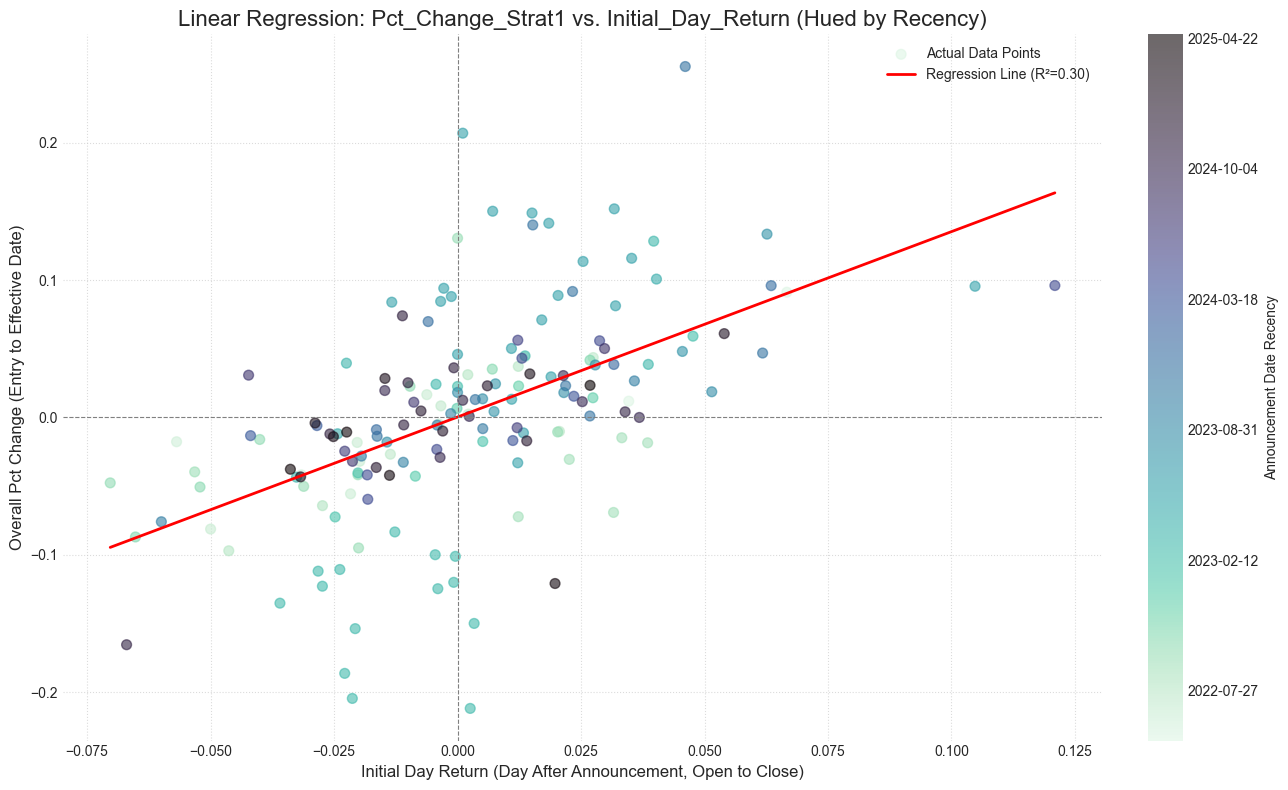


Model Interpretation Hints:
- Intercept (0.0003): Predicted Pct_Change_Strat1 if Initial_Day_Return is 0.
- Slope (1.3487): For each 1% (0.01) increase in Initial_Day_Return, Pct_Change_Strat1 is predicted to change by 0.0135 (or 1.35%).
- R-squared (0.2984): About 29.84% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.
- P>|t| for Initial_Day_Return: If < 0.05, the Initial_Day_Return is a statistically significant predictor.


In [ ]:
import statsmodels.api as sm # For detailed regression statistics
regression_df = df_events_cleaned[['Initial_Day_Return', 'Pct_Change_Strat1', 'Announce_Date']].dropna().copy()

if regression_df.empty or len(regression_df) < 2:
    print("Not enough valid data points to fit a linear regression model after dropping NaNs.")
else:
    Y = regression_df['Pct_Change_Strat1']
    X = regression_df['Initial_Day_Return']
    X_with_const = sm.add_constant(X) # Add intercept term

    # 2. Fit the OLS model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # 3. Print the model summary
    print("\n--- Linear Regression Model Summary ---")
    print(results.summary())

    intercept_val = results.params['const']
    slope_val = results.params['Initial_Day_Return']
    r_squared_val = results.rsquared

    print(f"\nFitted Model Equation: Expected_Pct_Change_Strat1 = {intercept_val:.4f} + ({slope_val:.4f} * Initial_Day_Return)")
    print(f"R-squared: {r_squared_val:.4f}")

    # 4. Visualize the Fit (using the colorbar approach for recency)
    regression_df['Announce_Date_Num'] = regression_df['Announce_Date'].map(mdates.date2num)

    fig, ax = plt.subplots(figsize=(13, 8))

    norm = plt.Normalize(regression_df['Announce_Date_Num'].min(), regression_df['Announce_Date_Num'].max())

    points = ax.scatter(
        regression_df['Initial_Day_Return'],
        regression_df['Pct_Change_Strat1'],
        c=regression_df['Announce_Date_Num'],
        cmap='mako_r',
        norm=norm,
        alpha=0.6,
        s=50,
        label='Actual Data Points' # Label for scatter points (though legend might be complex with hue)
    )

    # Plot the regression line from the model
    # Generate x-values for the line covering the range of Initial_Day_Return
    x_line_fit = np.array([regression_df['Initial_Day_Return'].min(), regression_df['Initial_Day_Return'].max()])
    y_line_fit = results.predict(sm.add_constant(pd.DataFrame({'Initial_Day_Return': x_line_fit}))) # Use model.predict

    ax.plot(x_line_fit, y_line_fit, color='red', linewidth=2, label=f'Regression Line (R²={r_squared_val:.2f})')

    ax.set_title('Linear Regression: Pct_Change_Strat1 vs. Initial_Day_Return (Hued by Recency)', fontsize=16)
    ax.set_xlabel('Initial Day Return (Day After Announcement, Open to Close)', fontsize=12)
    ax.set_ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Colorbar
    cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Announcement Date Recency', fontsize=10)
    cbar_ticks_num = cbar.get_ticks()
    cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
    cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])

    ax.legend(loc='best') # Show legend for regression line and potentially scatter if labeled
    plt.tight_layout()
    plt.show()

    print("\nModel Interpretation Hints:")
    print(f"- Intercept ({intercept_val:.4f}): Predicted Pct_Change_Strat1 if Initial_Day_Return is 0.")
    print(f"- Slope ({slope_val:.4f}): For each 1% (0.01) increase in Initial_Day_Return, Pct_Change_Strat1 is predicted to change by {slope_val*0.01:.4f} (or {slope_val:.2f}%).")
    print(f"- R-squared ({r_squared_val:.4f}): About {r_squared_val*100:.2f}% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.")
    print("- P>|t| for Initial_Day_Return: If < 0.05, the Initial_Day_Return is a statistically significant predictor.")


--- Linear Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:      Pct_Change_Strat1   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     69.76
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.68e-14
Time:                        20:31:37   Log-Likelihood:                 227.57
No. Observations:                 166   AIC:                            -451.1
Df Residuals:                     164   BIC:                            -444.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

C:\Users\evans\AppData\Local\Temp\ipykernel_42376\2821110311.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


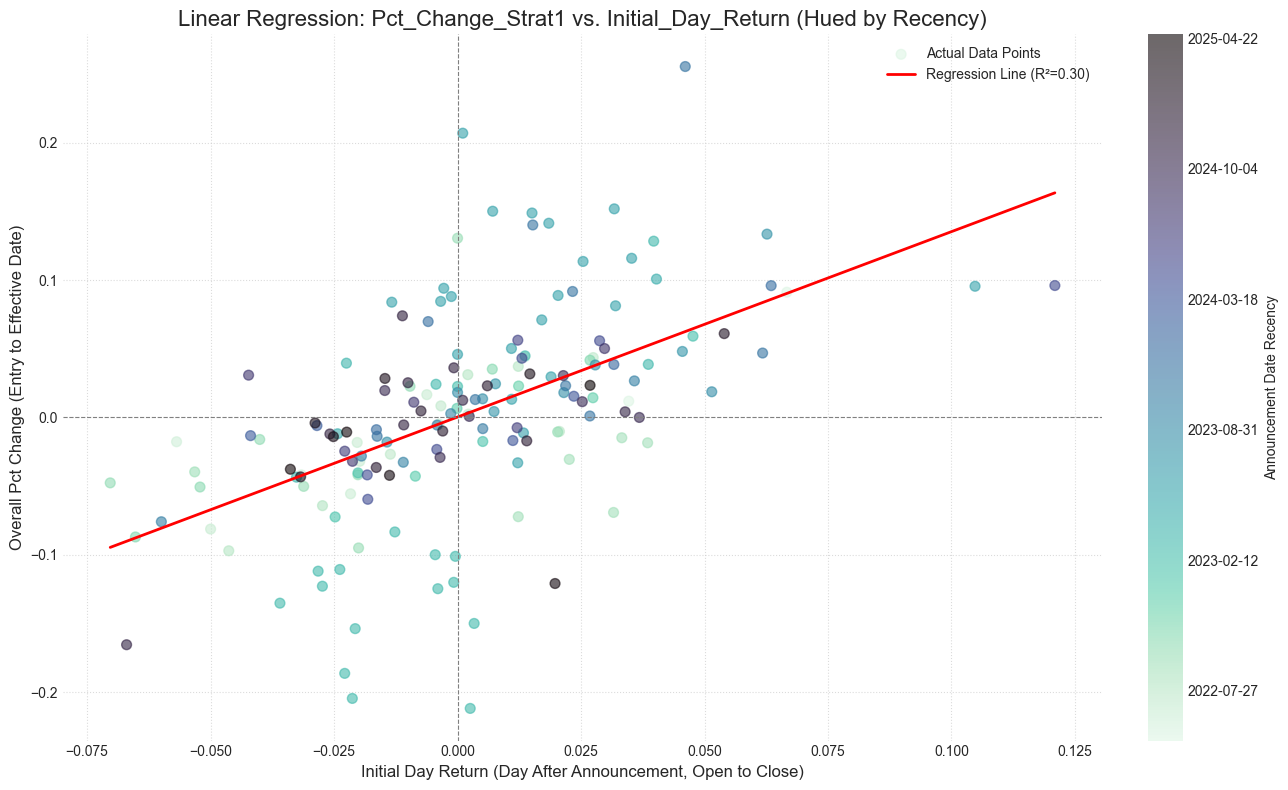


Model Interpretation Hints:
- Intercept (0.0003): Predicted Pct_Change_Strat1 if Initial_Day_Return is 0.
- Slope (1.3487): For each 1% (0.01) increase in Initial_Day_Return, Pct_Change_Strat1 is predicted to change by 0.0135 (or 1.35%).
- R-squared (0.2984): About 29.84% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.
- P>|t| for Initial_Day_Return: If < 0.05, the Initial_Day_Return is a statistically significant predictor.


In [ ]:
import statsmodels.api as sm # For detailed regression statistics
regression_df = df_events_cleaned[['Initial_Day_Return', 'Pct_Change_Strat1', 'Announce_Date']].dropna().copy()

if regression_df.empty or len(regression_df) < 2:
    print("Not enough valid data points to fit a linear regression model after dropping NaNs.")
else:
    Y = regression_df['Pct_Change_Strat1']
    X = regression_df['Initial_Day_Return']
    X_with_const = sm.add_constant(X) # Add intercept term

    # 2. Fit the OLS model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # 3. Print the model summary
    print("\n--- Linear Regression Model Summary ---")
    print(results.summary())

    intercept_val = results.params['const']
    slope_val = results.params['Initial_Day_Return']
    r_squared_val = results.rsquared

    print(f"\nFitted Model Equation: Expected_Pct_Change_Strat1 = {intercept_val:.4f} + ({slope_val:.4f} * Initial_Day_Return)")
    print(f"R-squared: {r_squared_val:.4f}")

    # 4. Visualize the Fit (using the colorbar approach for recency)
    regression_df['Announce_Date_Num'] = regression_df['Announce_Date'].map(mdates.date2num)

    fig, ax = plt.subplots(figsize=(13, 8))

    norm = plt.Normalize(regression_df['Announce_Date_Num'].min(), regression_df['Announce_Date_Num'].max())

    points = ax.scatter(
        regression_df['Initial_Day_Return'],
        regression_df['Pct_Change_Strat1'],
        c=regression_df['Announce_Date_Num'],
        cmap='mako_r',
        norm=norm,
        alpha=0.6,
        s=50,
        label='Actual Data Points' # Label for scatter points (though legend might be complex with hue)
    )

    # Plot the regression line from the model
    # Generate x-values for the line covering the range of Initial_Day_Return
    x_line_fit = np.array([regression_df['Initial_Day_Return'].min(), regression_df['Initial_Day_Return'].max()])
    y_line_fit = results.predict(sm.add_constant(pd.DataFrame({'Initial_Day_Return': x_line_fit}))) # Use model.predict

    ax.plot(x_line_fit, y_line_fit, color='red', linewidth=2, label=f'Regression Line (R²={r_squared_val:.2f})')

    ax.set_title('Linear Regression: Pct_Change_Strat1 vs. Initial_Day_Return (Hued by Recency)', fontsize=16)
    ax.set_xlabel('Initial Day Return (Day After Announcement, Open to Close)', fontsize=12)
    ax.set_ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Colorbar
    cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Announcement Date Recency', fontsize=10)
    cbar_ticks_num = cbar.get_ticks()
    cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
    cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])

    ax.legend(loc='best') # Show legend for regression line and potentially scatter if labeled
    plt.tight_layout()
    plt.show()

    print("\nModel Interpretation Hints:")
    print(f"- Intercept ({intercept_val:.4f}): Predicted Pct_Change_Strat1 if Initial_Day_Return is 0.")
    print(f"- Slope ({slope_val:.4f}): For each 1% (0.01) increase in Initial_Day_Return, Pct_Change_Strat1 is predicted to change by {slope_val*0.01:.4f} (or {slope_val:.2f}%).")
    print(f"- R-squared ({r_squared_val:.4f}): About {r_squared_val*100:.2f}% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.")
    print("- P>|t| for Initial_Day_Return: If < 0.05, the Initial_Day_Return is a statistically significant predictor.")

Fitting Linear Regression Model: Pct_Change_Strat1 ~ Initial_Day_Return

--- Linear Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:      Pct_Change_Strat1   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     69.76
Date:                Thu, 22 May 2025   Prob (F-statistic):           2.68e-14
Time:                        20:31:37   Log-Likelihood:                 227.57
No. Observations:                 166   AIC:                            -451.1
Df Residuals:                     164   BIC:                            -444.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------

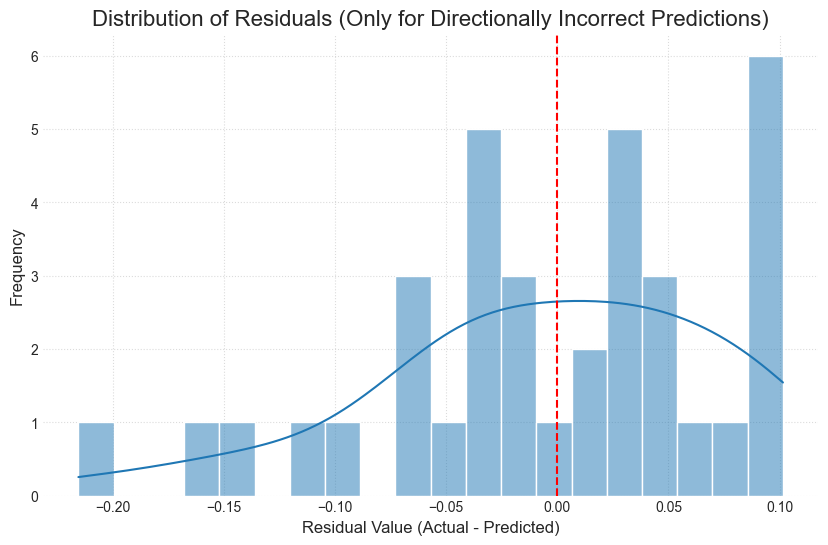


--- Overall Error Metrics (All Predictions for reference) ---
Overall MAE: 0.0429
Overall Max Absolute Error: 0.2155


C:\Users\evans\AppData\Local\Temp\ipykernel_42376\3625603904.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


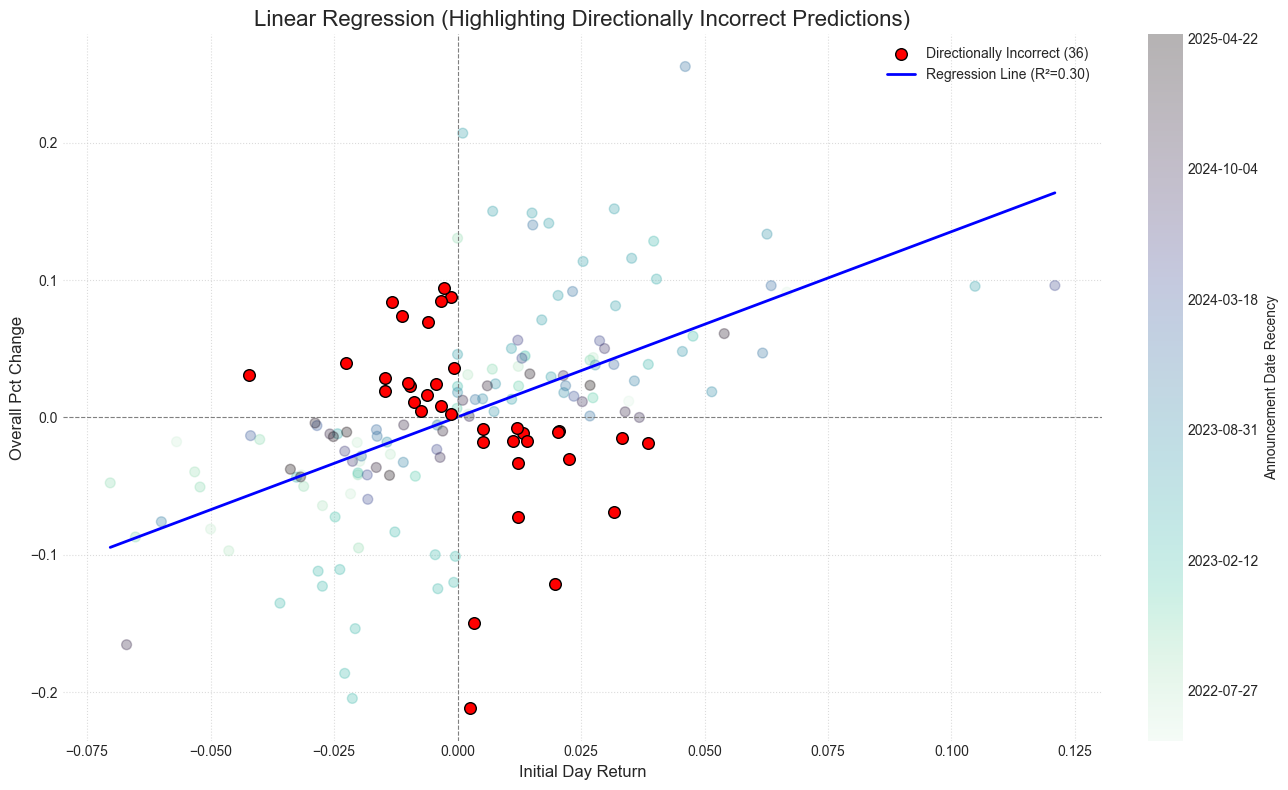

In [ ]:

from sklearn.metrics import mean_absolute_error
print("Fitting Linear Regression Model: Pct_Change_Strat1 ~ Initial_Day_Return")

regression_df = df_events_cleaned[['Initial_Day_Return', 'Pct_Change_Strat1', 'Announce_Date']].dropna().copy()

if regression_df.empty or len(regression_df) < 2:
    print("Not enough valid data points to fit a linear regression model after dropping NaNs.")
else:
    Y_actual = regression_df['Pct_Change_Strat1']
    X_reg = regression_df['Initial_Day_Return']
    X_with_const = sm.add_constant(X_reg)

    model = sm.OLS(Y_actual, X_with_const)
    results = model.fit()

    print("\n--- Linear Regression Model Summary ---")
    print(results.summary())
    # ... (other summary printouts) ...

    Y_predicted = results.predict(X_with_const)
    residuals_all = Y_actual - Y_predicted

    # --- Identify Directionally Incorrect Predictions ---
    # A prediction is directionally incorrect if sign(actual) * sign(predicted) == -1
    # This handles cases where one is positive and the other is negative.
    # It excludes cases where either actual or predicted is exactly zero if np.sign(0) is 0.
    # Or, more explicitly: (Actual > 0 and Predicted < 0) OR (Actual < 0 and Predicted > 0)

    # Let's define a small tolerance for "zero" to avoid issues with floating point comparisons
    # if we wanted to include cases like Actual=0, Predicted > 0.
    # For now, strict sign opposition is:
    directionally_incorrect_mask = (np.sign(Y_actual) * np.sign(Y_predicted)) == -1

    # Alternative explicit definition that handles 0 differently:
    # directionally_incorrect_mask = (
    #    ((Y_actual > 0) & (Y_predicted < 0)) |
    #    ((Y_actual < 0) & (Y_predicted > 0))
    # )
    # Add these if you want to count predicting non-zero when actual is zero as directionally wrong:
    # | ((Y_actual == 0) & (Y_predicted != 0))
    # | ((Y_actual != 0) & (Y_predicted == 0))


    Y_actual_di = Y_actual[directionally_incorrect_mask]
    Y_predicted_di = Y_predicted[directionally_incorrect_mask]
    residuals_di = residuals_all[directionally_incorrect_mask]

    num_directionally_incorrect = directionally_incorrect_mask.sum()
    total_predictions = len(Y_actual)

    print(f"\n--- Directionally Incorrect Prediction Analysis ---")
    if num_directionally_incorrect > 0:
        di_mae = mean_absolute_error(Y_actual_di, Y_predicted_di)
        print(f"Number of Directionally Incorrect Predictions: {num_directionally_incorrect} out of {total_predictions} ({num_directionally_incorrect/total_predictions:.2%})")
        print(f"Mean Absolute Error (MAE) for Directionally Incorrect Predictions (DI-MAE): {di_mae:.4f}")

        print("\nResiduals for Directionally Incorrect Predictions:")
        print(f"  Mean Residual: {residuals_di.mean():.4f}")
        print(f"  Std Dev of Residuals: {residuals_di.std():.4f}")
        print(f"  Min Residual: {residuals_di.min():.4f}")
        print(f"  Max Residual: {residuals_di.max():.4f}")
        print("  Percentiles of Residuals (Directionally Incorrect):")
        print(f"    25th: {np.percentile(residuals_di, 25):.4f}")
        print(f"    50th (Median): {np.percentile(residuals_di, 50):.4f}")
        print(f"    75th: {np.percentile(residuals_di, 75):.4f}")

        plt.figure(figsize=(10, 6))
        sns.histplot(residuals_di, kde=True, bins=20 if num_directionally_incorrect > 20 else 5)
        plt.title('Distribution of Residuals (Only for Directionally Incorrect Predictions)', fontsize=16)
        plt.xlabel('Residual Value (Actual - Predicted)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(0, color='red', linestyle='--')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
    else:
        print("No directionally incorrect predictions found with the current criteria.")

    # --- Overall Error Metrics (repeated for context, already calculated before) ---
    mae_all = mean_absolute_error(Y_actual, Y_predicted)
    max_abs_error_all = np.max(np.abs(residuals_all))
    print(f"\n--- Overall Error Metrics (All Predictions for reference) ---")
    print(f"Overall MAE: {mae_all:.4f}")
    print(f"Overall Max Absolute Error: {max_abs_error_all:.4f}")
    # ... (RMSE, etc. from summary)

    # ... (Scatter plot code remains the same as before) ...
    # (Optional: You could highlight the directionally incorrect points on the scatter plot too)
    regression_df['Announce_Date_Num'] = regression_df['Announce_Date'].map(mdates.date2num)
    fig, ax = plt.subplots(figsize=(13, 8))
    norm = plt.Normalize(regression_df['Announce_Date_Num'].min(), regression_df['Announce_Date_Num'].max())

    # Plot all points first
    points = ax.scatter(
        regression_df['Initial_Day_Return'],
        regression_df['Pct_Change_Strat1'],
        c=regression_df['Announce_Date_Num'], cmap='mako_r', norm=norm, alpha=0.3, s=50, label='_nolegend_' # Make them fainter
    )

    # Highlight directionally incorrect points
    if num_directionally_incorrect > 0:
        ax.scatter(
            X_reg[directionally_incorrect_mask], # X values for DI points
            Y_actual[directionally_incorrect_mask],   # Y_actual values for DI points
            color='red',
            edgecolor='black',
            s=70,
            label=f'Directionally Incorrect ({num_directionally_incorrect})',
            zorder=3 # Plot on top
        )

    x_line_fit = np.array([regression_df['Initial_Day_Return'].min(), regression_df['Initial_Day_Return'].max()])
    y_line_fit = results.predict(sm.add_constant(pd.DataFrame({'Initial_Day_Return': x_line_fit})))
    ax.plot(x_line_fit, y_line_fit, color='blue', linewidth=2, label=f'Regression Line (R²={results.rsquared:.2f})') # Changed line color for contrast
    ax.set_title('Linear Regression (Highlighting Directionally Incorrect Predictions)', fontsize=16)
    ax.set_xlabel('Initial Day Return', fontsize=12)
    ax.set_ylabel('Overall Pct Change', fontsize=12)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.grid(True, linestyle=':', alpha=0.7)
    cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04) # Colorbar for original hue
    cbar.set_label('Announcement Date Recency', fontsize=10)
    cbar_ticks_num = cbar.get_ticks()
    cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
    cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [22]:
df_events_cleaned

,Announce_Date,Trade_Date,Index,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade,Announced_Date_Orig,Trade_Date_Orig,Ticker_Orig,Normalized_Ticker,ADV to Trade Pct,Entry_Date_Strat1,Entry_Price_Strat1,Exit_Date_Strat1,Exit_Price_Strat1,Pct_Change_Strat1,Abs_Pct_Change_Strat1,Initial_Day_Return,Close_Price_Entry_Date_Strat1,Initial_2Day_Return,Initial_5Day_Return,Total_Event_Trading_Days
0,2022-05-12,2022-05-18,S&P 600,AOSL,Add,33.20,Info Tech,2772855.0,92.1,468%,5/12/2022,5/18/2022,AOSL,AOSL,4.68,2022-05-13,38.230000,2022-05-18,39.910000,0.043945,0.043945,0.013602,38.750000,0.008109,0.054669,5.0
1,2022-05-12,2022-05-18,S&P 400,IRT,Add,22.44,Real Estate,24230554.0,543.7,689%,5/12/2022,5/18/2022,IRT,IRT,6.89,2022-05-13,19.733495,2022-05-18,19.967451,0.011856,0.011856,0.034656,20.417374,0.025080,0.017328,5.0
2,2022-05-12,2022-05-16,S&P 600,DVAX,Add,7.93,Healthcare,14658374.0,116.2,846%,5/12/2022,5/16/2022,DVAX,DVAX,8.46,2022-05-13,9.000000,2022-05-16,9.820000,0.091111,0.091111,0.066667,9.600000,0.091111,0.242222,3.0
3,2022-06-03,2022-06-07,S&P 500,VICI,Add,32.45,Real Estate,146440651.0,4752.0,906%,6/3/2022,6/7/2022,VICI,VICI,9.06,2022-06-06,28.641829,2022-06-07,27.445217,-0.041778,0.041778,-0.031632,27.735823,-0.041778,-0.106535,3.0
4,2022-06-13,2022-06-15,S&P 600,EYE,Add,39.62,Cons Disc,11230796.0,NaN,1617%,6/13/2022,6/15/2022,EYE,EYE,16.17,2022-06-14,28.299999,2022-06-15,27.799999,-0.017668,0.017668,-0.056890,26.690001,-0.017668,-0.055477,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2025-03-26,2025-03-28,S&P 400,CAVA US,Add,86.67,Cons Disc,8961552.0,776.7,223%,3/26/2025,3/28/2025,CAVA US,CAVA,2.23,2025-03-27,89.625000,2025-03-28,85.849998,-0.042120,0.042120,-0.013780,88.389999,-0.042120,0.008089,3.0
163,2025-03-26,2025-04-01,S&P 600,ANGI US,Add,16.43,Comm Svcs,886941.0,14.6,454%,3/26/2025,4/1/2025,ANGI US,ANGI,4.54,2025-03-27,16.719999,2025-04-01,14.700000,-0.120813,0.120813,0.019737,17.049999,-0.047847,-0.162679,5.0
164,2025-04-09,2025-04-15,S&P 600,ACT US,Add,33.37,Financials,3863743.0,128.9,1536%,4/9/2025,4/15/2025,ACT US,ACT,15.36,2025-04-10,35.435898,2025-04-15,35.058071,-0.010662,0.010662,-0.022447,34.640480,-0.007576,-0.029181,5.0
165,2025-04-14,2025-04-16,S&P 600,STRL US,Add,135.23,Industrials,4004975.0,541.6,528%,4/14/2025,4/16/2025,STRL US,STRL,5.28,2025-04-15,145.940002,2025-04-16,140.440002,-0.037687,0.037687,-0.033850,141.000000,-0.037687,-0.082363,3.0


In [ ]:
df_events_cleaned['3_Day_Return'] = np.nan

# Ensure stock_price_data_multi is sorted for the helper function
if not stock_price_data_multi.index.is_monotonic_increasing:
    print("asdfasf")
    stock_price_data_multi.sort_index(inplace=True)

for index, event_row in df_events_cleaned.iterrows():
    ticker = event_row['Normalized_Ticker']
    # Entry_Date_Strat1 is the first day (Day 1) where we get the Open price
    entry_date_day1 = event_row['Entry_Date_Strat1']
    entry_price_open_day1 = event_row['Entry_Price_Strat1']

    if pd.isna(entry_date_day1) or pd.isna(entry_price_open_day1) or entry_price_open_day1 == 0:
        continue

    # We need the close price of the 3rd trading day from and including entry_date_day1.
    # So, n_trading_days_from_start = 3.
    close_price_day3 = get_nth_day_close(ticker, entry_date_day1, 3, stock_price_data_multi)

    if pd.notna(close_price_day3):
        three_day_return = (close_price_day3 - entry_price_open_day1) / entry_price_open_day1
        df_events_cleaned.loc[index, '3_Day_Return'] = three_day_return
    #else:
        # print(f"Could not calculate 3_Day_Return for {ticker} on event index {index} (Entry Date: {entry_date_day1}). Close_price_day3 was NaN.")


print("\nCalculation complete. '3_Day_Return' added to df_events_cleaned.")
print("Sample of df_events_cleaned with the new column:")
print(df_events_cleaned[['Normalized_Ticker', 'Entry_Date_Strat1', 'Entry_Price_Strat1', '3_Day_Return']].head())
print("\nDescriptive statistics for '3_Day_Return':")
print(df_events_cleaned['3_Day_Return'].describe())

# Verify some calculations manually if using placeholder data or have small dataset
# Example for first few non-NaN results:
for i, row in df_events_cleaned.dropna(subset=['3_Day_Return']).head(2).iterrows():
    print(f"\nVerification for event index {i}, Ticker: {row['Normalized_Ticker']}")
    print(f"Entry_Date_Strat1 (Day 1): {row['Entry_Date_Strat1'].date()}, Open Price: {row['Entry_Price_Strat1']:.2f}")
    day1_data = stock_price_data_multi.loc[(row['Entry_Date_Strat1'], row['Normalized_Ticker'])]
    print(f"  Day 1 Close: {day1_data['Close']:.2f}")

# Find Day 2 and Day 3
    ticker_days = stock_price_data_multi.loc[(slice(row['Entry_Date_Strat1'], row['Trade_Date']), row['Normalized_Ticker']), :].reset_index()
    print(ticker_days)
    if len(ticker_days) > 1:
        day2_date = ticker_days.iloc[1]['Date']
        print(day2_date)
        day2_data = stock_price_data_multi.loc[(day2_date, row['Normalized_Ticker']),]
        print(f"  Day 2 ({day2_date.date()}) Close: {day2_data['Close']:.2f}")
    if len(ticker_days) > 2:
        day3_date = ticker_days.iloc[2]['Date']
        day3_data = stock_price_data_multi.loc[(day3_date, row['Normalized_Ticker'])]
        print(f"  Day 3 ({day3_date.date()}) Close: {day3_data['Close']:.2f} (Used for 3_Day_Return calc)")
print(f"Calculated 3_Day_Return: {row['3_Day_Return']:.4f}")


Calculation complete. '3_Day_Return' added to df_events_cleaned.
Sample of df_events_cleaned with the new column:
  Normalized_Ticker Entry_Date_Strat1  Entry_Price_Strat1  3_Day_Return
0              AOSL        2022-05-13           38.230000      0.061470
1               IRT        2022-05-13           19.733495      0.034200
2              DVAX        2022-05-13            9.000000      0.081111
3              VICI        2022-06-06           28.641829     -0.061176
4               EYE        2022-06-14           28.299999     -0.078799

Descriptive statistics for '3_Day_Return':
count    166.000000
mean      -0.003427
std        0.050787
min       -0.171304
25%       -0.032064
50%       -0.001089
75%        0.028364
max        0.134249
Name: 3_Day_Return, dtype: float64

Verification for event index 0, Ticker: AOSL
Entry_Date_Strat1 (Day 1): 2022-05-13, Open Price: 38.23
  Day 1 Close: 38.75
Price       Date Ticker       Open   High        Low      Close     Volume  \
0     2022-0


--- Linear Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:      Pct_Change_Strat1   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     117.8
Date:                Thu, 22 May 2025   Prob (F-statistic):           5.04e-21
Time:                        21:01:07   Log-Likelihood:                 243.09
No. Observations:                 166   AIC:                            -482.2
Df Residuals:                     164   BIC:                            -475.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const  

C:\Users\evans\AppData\Local\Temp\ipykernel_42376\1254869315.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


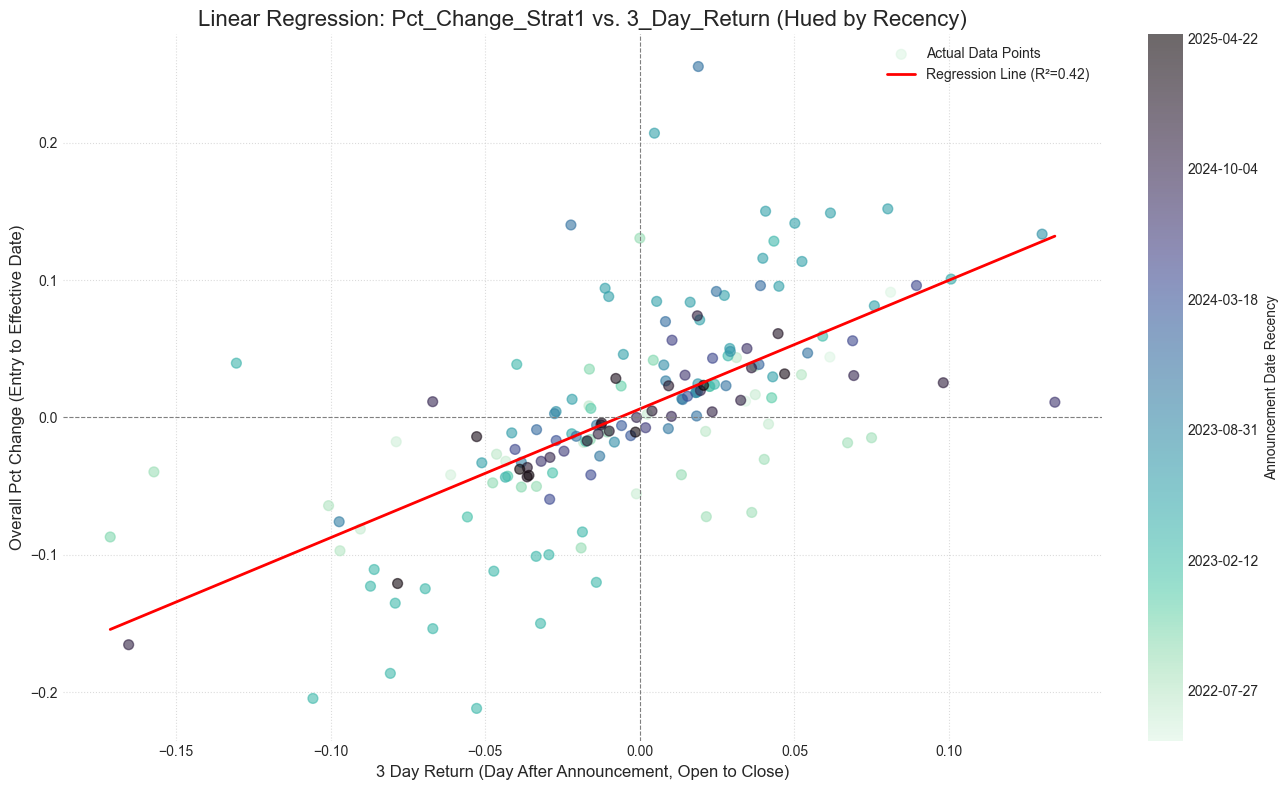


Model Interpretation Hints:
- Intercept (0.0062): Predicted Pct_Change_Strat1 if 3_Day_Return is 0.
- Slope (0.9365): For each 1% (0.01) increase in 3_Day_Return, Pct_Change_Strat1 is predicted to change by 0.0094 (or 0.94%).
- R-squared (0.4180): About 41.80% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.
- P>|t| for 3_Day_Return: If < 0.05, the 3_Day_Return is a statistically significant predictor.


In [ ]:
regression_df = df_events_cleaned[['3_Day_Return', 'Pct_Change_Strat1', 'Announce_Date']].dropna().copy()

if regression_df.empty or len(regression_df) < 2:
    print("Not enough valid data points to fit a linear regression model after dropping NaNs.")
else:
    Y = regression_df['Pct_Change_Strat1']
    X = regression_df['3_Day_Return']
    X_with_const = sm.add_constant(X) # Add intercept term

    # 2. Fit the OLS model
    model = sm.OLS(Y, X_with_const)
    results = model.fit()

    # 3. Print the model summary
    print("\n--- Linear Regression Model Summary ---")
    print(results.summary())

    intercept_val = results.params['const']
    slope_val = results.params['3_Day_Return']
    r_squared_val = results.rsquared

    print(f"\nFitted Model Equation: Expected_Pct_Change_Strat1 = {intercept_val:.4f} + ({slope_val:.4f} * 3_Day_Return)")
    print(f"R-squared: {r_squared_val:.4f}")

    # 4. Visualize the Fit (using the colorbar approach for recency)
    regression_df['Announce_Date_Num'] = regression_df['Announce_Date'].map(mdates.date2num)

    fig, ax = plt.subplots(figsize=(13, 8))

    norm = plt.Normalize(regression_df['Announce_Date_Num'].min(), regression_df['Announce_Date_Num'].max())

    points = ax.scatter(
        regression_df['3_Day_Return'],
        regression_df['Pct_Change_Strat1'],
        c=regression_df['Announce_Date_Num'],
        cmap='mako_r',
        norm=norm,
        alpha=0.6,
        s=50,
        label='Actual Data Points' # Label for scatter points (though legend might be complex with hue)
    )

    # Plot the regression line from the model
    # Generate x-values for the line covering the range of Initial_Day_Return
    x_line_fit = np.array([regression_df['3_Day_Return'].min(), regression_df['3_Day_Return'].max()])
    y_line_fit = results.predict(sm.add_constant(pd.DataFrame({'3_Day_Return': x_line_fit}))) # Use model.predict

    ax.plot(x_line_fit, y_line_fit, color='red', linewidth=2, label=f'Regression Line (R²={r_squared_val:.2f})')

    ax.set_title('Linear Regression: Pct_Change_Strat1 vs. 3_Day_Return (Hued by Recency)', fontsize=16)
    ax.set_xlabel('3 Day Return (Day After Announcement, Open to Close)', fontsize=12)
    ax.set_ylabel('Overall Pct Change (Entry to Effective Date)', fontsize=12)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.grid(True, linestyle=':', alpha=0.7)

    # Colorbar
    cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Announcement Date Recency', fontsize=10)
    cbar_ticks_num = cbar.get_ticks()
    cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
    cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])

    ax.legend(loc='best') # Show legend for regression line and potentially scatter if labeled
    plt.tight_layout()
    plt.show()

    print("\nModel Interpretation Hints:")
    print(f"- Intercept ({intercept_val:.4f}): Predicted Pct_Change_Strat1 if 3_Day_Return is 0.")
    print(f"- Slope ({slope_val:.4f}): For each 1% (0.01) increase in 3_Day_Return, Pct_Change_Strat1 is predicted to change by {slope_val*0.01:.4f} (or {slope_val:.2f}%).")
    print(f"- R-squared ({r_squared_val:.4f}): About {r_squared_val*100:.2f}% of the variation in Pct_Change_Strat1 can be explained by Initial_Day_Return.")
    print("- P>|t| for 3_Day_Return: If < 0.05, the 3_Day_Return is a statistically significant predictor.")

Fitting Linear Regression Model: Pct_Change_Strat1 ~ Initial_Day_Return

--- Linear Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:      Pct_Change_Strat1   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     117.8
Date:                Thu, 22 May 2025   Prob (F-statistic):           5.04e-21
Time:                        21:03:17   Log-Likelihood:                 243.09
No. Observations:                 166   AIC:                            -482.2
Df Residuals:                     164   BIC:                            -475.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
----------------

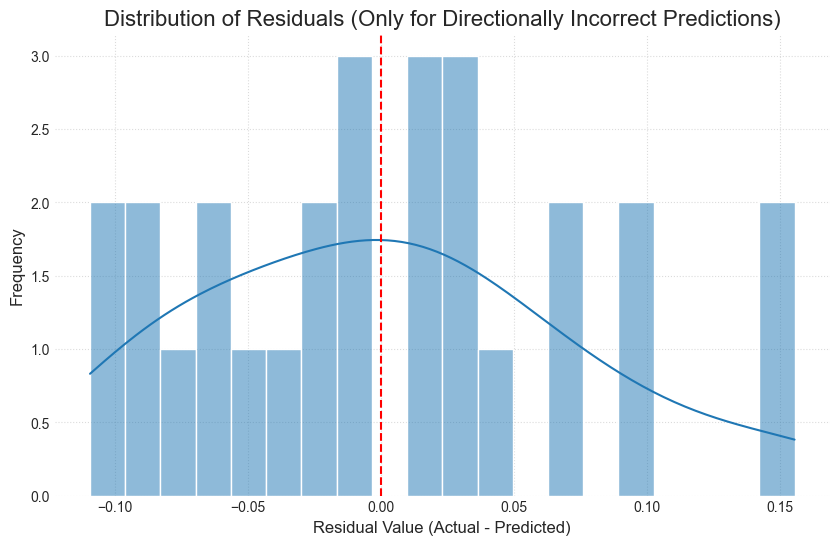


--- Overall Error Metrics (All Predictions for reference) ---
Overall MAE: 0.0375
Overall Max Absolute Error: 0.2314


C:\Users\evans\AppData\Local\Temp\ipykernel_42376\4250141374.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])


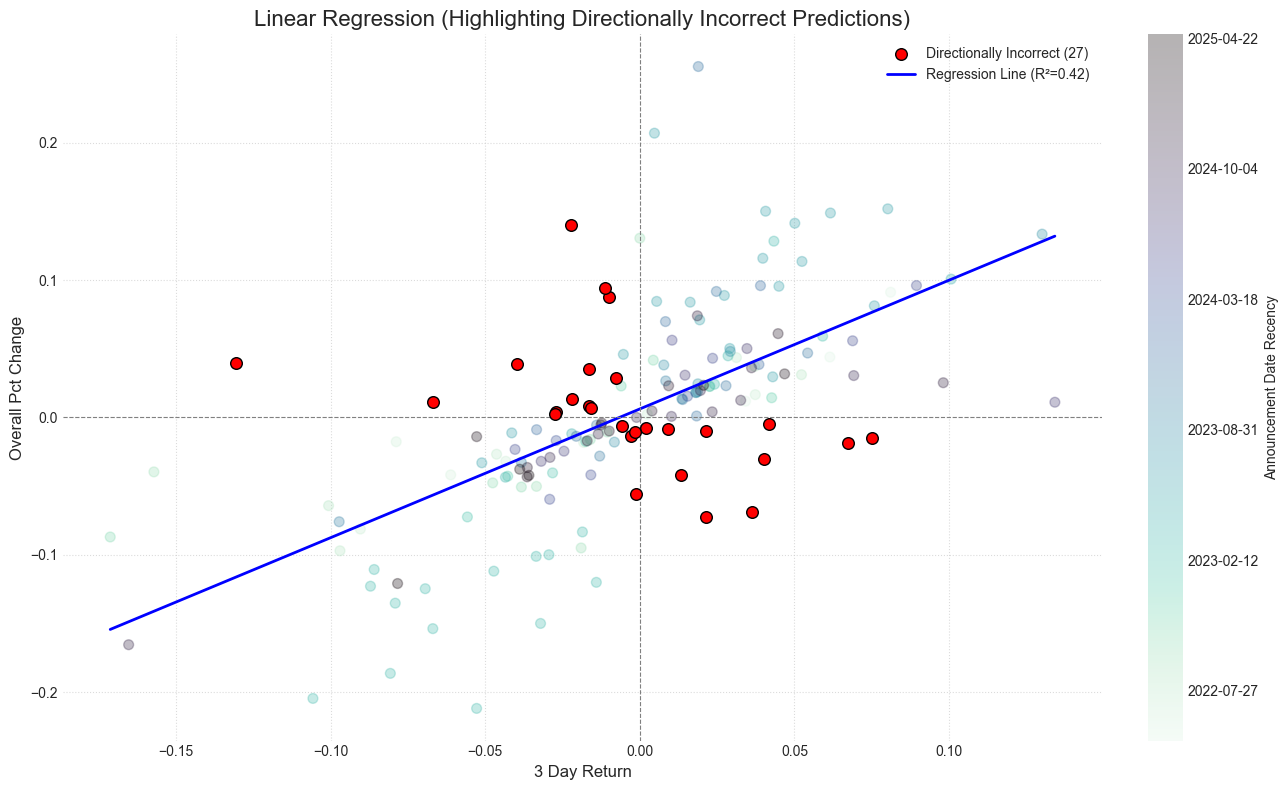

In [ ]:

from sklearn.metrics import mean_absolute_error
print("Fitting Linear Regression Model: Pct_Change_Strat1 ~ Initial_Day_Return")

regression_df = df_events_cleaned[['3_Day_Return', 'Pct_Change_Strat1', 'Announce_Date']].dropna().copy()

if regression_df.empty or len(regression_df) < 2:
    print("Not enough valid data points to fit a linear regression model after dropping NaNs.")
else:
    Y_actual = regression_df['Pct_Change_Strat1']
    X_reg = regression_df['3_Day_Return']
    X_with_const = sm.add_constant(X_reg)

    model = sm.OLS(Y_actual, X_with_const)
    results = model.fit()

    print("\n--- Linear Regression Model Summary ---")
    print(results.summary())
    # ... (other summary printouts) ...

    Y_predicted = results.predict(X_with_const)
    residuals_all = Y_actual - Y_predicted

    # --- Identify Directionally Incorrect Predictions ---
    # A prediction is directionally incorrect if sign(actual) * sign(predicted) == -1
    # This handles cases where one is positive and the other is negative.
    # It excludes cases where either actual or predicted is exactly zero if np.sign(0) is 0.
    # Or, more explicitly: (Actual > 0 and Predicted < 0) OR (Actual < 0 and Predicted > 0)

    # Let's define a small tolerance for "zero" to avoid issues with floating point comparisons
    # if we wanted to include cases like Actual=0, Predicted > 0.
    # For now, strict sign opposition is:
    directionally_incorrect_mask = (np.sign(Y_actual) * np.sign(Y_predicted)) == -1

    # Alternative explicit definition that handles 0 differently:
    # directionally_incorrect_mask = (
    #    ((Y_actual > 0) & (Y_predicted < 0)) |
    #    ((Y_actual < 0) & (Y_predicted > 0))
    # )
    # Add these if you want to count predicting non-zero when actual is zero as directionally wrong:
    # | ((Y_actual == 0) & (Y_predicted != 0))
    # | ((Y_actual != 0) & (Y_predicted == 0))


    Y_actual_di = Y_actual[directionally_incorrect_mask]
    Y_predicted_di = Y_predicted[directionally_incorrect_mask]
    residuals_di = residuals_all[directionally_incorrect_mask]

    num_directionally_incorrect = directionally_incorrect_mask.sum()
    total_predictions = len(Y_actual)

    print(f"\n--- Directionally Incorrect Prediction Analysis ---")
    if num_directionally_incorrect > 0:
        di_mae = mean_absolute_error(Y_actual_di, Y_predicted_di)
        print(f"Number of Directionally Incorrect Predictions: {num_directionally_incorrect} out of {total_predictions} ({num_directionally_incorrect/total_predictions:.2%})")
        print(f"Mean Absolute Error (MAE) for Directionally Incorrect Predictions (DI-MAE): {di_mae:.4f}")

        print("\nResiduals for Directionally Incorrect Predictions:")
        print(f"  Mean Residual: {residuals_di.mean():.4f}")
        print(f"  Std Dev of Residuals: {residuals_di.std():.4f}")
        print(f"  Min Residual: {residuals_di.min():.4f}")
        print(f"  Max Residual: {residuals_di.max():.4f}")
        print("  Percentiles of Residuals (Directionally Incorrect):")
        print(f"    25th: {np.percentile(residuals_di, 25):.4f}")
        print(f"    50th (Median): {np.percentile(residuals_di, 50):.4f}")
        print(f"    75th: {np.percentile(residuals_di, 75):.4f}")

        plt.figure(figsize=(10, 6))
        sns.histplot(residuals_di, kde=True, bins=20 if num_directionally_incorrect > 20 else 5)
        plt.title('Distribution of Residuals (Only for Directionally Incorrect Predictions)', fontsize=16)
        plt.xlabel('Residual Value (Actual - Predicted)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(0, color='red', linestyle='--')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
    else:
        print("No directionally incorrect predictions found with the current criteria.")

    # --- Overall Error Metrics (repeated for context, already calculated before) ---
    mae_all = mean_absolute_error(Y_actual, Y_predicted)
    max_abs_error_all = np.max(np.abs(residuals_all))
    print(f"\n--- Overall Error Metrics (All Predictions for reference) ---")
    print(f"Overall MAE: {mae_all:.4f}")
    print(f"Overall Max Absolute Error: {max_abs_error_all:.4f}")
    # ... (RMSE, etc. from summary)

    # ... (Scatter plot code remains the same as before) ...
    # (Optional: You could highlight the directionally incorrect points on the scatter plot too)
    regression_df['Announce_Date_Num'] = regression_df['Announce_Date'].map(mdates.date2num)
    fig, ax = plt.subplots(figsize=(13, 8))
    norm = plt.Normalize(regression_df['Announce_Date_Num'].min(), regression_df['Announce_Date_Num'].max())

    # Plot all points first
    points = ax.scatter(
        regression_df['3_Day_Return'],
        regression_df['Pct_Change_Strat1'],
        c=regression_df['Announce_Date_Num'], cmap='mako_r', norm=norm, alpha=0.3, s=50, label='_nolegend_' # Make them fainter
    )

    # Highlight directionally incorrect points
    if num_directionally_incorrect > 0:
        ax.scatter(
            X_reg[directionally_incorrect_mask], # X values for DI points
            Y_actual[directionally_incorrect_mask],   # Y_actual values for DI points
            color='red',
            edgecolor='black',
            s=70,
            label=f'Directionally Incorrect ({num_directionally_incorrect})',
            zorder=3 # Plot on top
        )

    x_line_fit = np.array([regression_df['3_Day_Return'].min(), regression_df['3_Day_Return'].max()])
    y_line_fit = results.predict(sm.add_constant(pd.DataFrame({'3_Day_Return': x_line_fit})))
    ax.plot(x_line_fit, y_line_fit, color='blue', linewidth=2, label=f'Regression Line (R²={results.rsquared:.2f})') # Changed line color for contrast
    ax.set_title('Linear Regression (Highlighting Directionally Incorrect Predictions)', fontsize=16)
    ax.set_xlabel('3 Day Return', fontsize=12)
    ax.set_ylabel('Overall Pct Change', fontsize=12)
    ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.axvline(0, color='grey', linestyle='--', linewidth=0.8)
    ax.grid(True, linestyle=':', alpha=0.7)
    cbar = fig.colorbar(points, ax=ax, orientation='vertical', fraction=0.046, pad=0.04) # Colorbar for original hue
    cbar.set_label('Announcement Date Recency', fontsize=10)
    cbar_ticks_num = cbar.get_ticks()
    cbar_tick_dates = [mdates.num2date(tick_val) for tick_val in cbar_ticks_num]
    cbar.set_ticklabels([date_obj.strftime('%Y-%m-%d') for date_obj in cbar_tick_dates])
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()